In [1]:
import random
import re
import pandas as pd
import json
from tqdm import tqdm
import pprint
from collections import defaultdict
# from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch
# from torch_kmeans import KMeans as TorchKMeans
from sklearn.decomposition import PCA
from umap.umap_ import UMAP
import numpy as np
import os
from transformers import RobertaTokenizer
# import faiss


filename = "pyedur_full.jsonl"

c:\Users\Oliver\miniconda3\envs\dl2-code-io\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def print_line(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        for i in range(random.randint(0,1630607)):
            f.readline()
        pprint.pp(f.readline())

def num_rows(file_path):
    count = 0
    with open(file_path, 'r', encoding='utf-8') as f:
        for _ in f:
            count += 1

    print(f'Total number of rows: {count}')
    return count

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
total_datapoints = num_rows('ast-pyedur_full.jsonl')

Total number of rows: 1630607


In [ ]:
print_line(filename)

{"prompt": "You are given a question that requires some input and output variables as follows:\n\nGiven a list of integers, how can we determine the smallest number using different divide-and-conquer strategies, or calculate the sum of elements at positions that are multiples of 3, or find the r-th root of a number with a specified precision?\n\nThe input and output requirements are as follows:\n\nInput:\n  `data` (list): A list of integers. For the 'root' operation, the list should contain exactly three elements: the number `n`, the root `r`, and the precision `p`.\n  `operation` (str): A string indicating the operation to perform. Valid values are 'min', 'minChip', 'sumMultiples', and 'root'.\n\nOutput:\n  `return` (int or float): The result of the specified operation. For 'min', 'minChip', and 'sumMultiples', it returns an integer. For 'root', it returns a float.\n\nGiven the following input:\n\n{'data': [-52, 83, 78, -31, -100, -56, 33, -32, -93, 38], 'operation': 'sumMultiples'}\n

In [ ]:
import json
import tiktoken

def average_prompt_tokens(file_path, model="gpt-3.5-turbo"):
    enc = tiktoken.encoding_for_model(model)
    total_tokens = 0
    total_prompts = 0

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                obj = json.loads(line)
                prompt = obj.get("prompt", "")
                token_count = len(enc.encode(prompt))
                total_tokens += token_count
                total_prompts += 1
            except json.JSONDecodeError:
                continue  # Skip malformed lines

    if total_prompts == 0:
        print("No valid prompts found.")
        return

    average = total_tokens / total_prompts
    print(f"Average number of tokens in 'prompt': {average:.2f}")


In [ ]:
average_prompt_tokens(filename)


Average number of tokens in 'prompt': 809.38


In [ ]:
def analyze_code_tokens_codebert(file_path, model_name="microsoft/codebert-base"):
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    total_tokens = 0
    total_codes = 0
    max_tokens = 0

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                obj = json.loads(line)
                code = obj.get("code", "")
                tokenized = tokenizer.encode(code, add_special_tokens=True)
                token_count = len(tokenized)
                total_tokens += token_count
                total_codes += 1
                max_tokens = max(max_tokens, token_count)
            except json.JSONDecodeError:
                continue  # Skip malformed lines

    if total_codes == 0:
        print("No valid code entries found.")
        return

    average = total_tokens / total_codes
    print(f"Average number of CodeBERT tokens in 'code': {average:.2f}")
    print(f"Maximum number of CodeBERT tokens in 'code': {max_tokens}")

In [ ]:
analyze_code_tokens_codebert('/content/drive/MyDrive/DL2/subset.jsonl')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1167 > 512). Running this sequence through the model will result in indexing errors


Average number of CodeBERT tokens in 'code': 898.05
Maximum number of CodeBERT tokens in 'code': 7125


In [ ]:
import json
import ast

# Extract code after the marker
def extract_code(prompt):
    marker = "You can refer to this code to guide your reasoning but not copy spans of code directly."
    if marker in prompt:
        return prompt.split(marker, 1)[-1].strip()
    return ""

# Convert code to AST
def code_to_ast(code):
    try:
        tree = ast.parse(code)
        return ast.dump(tree)
    except SyntaxError as e:
        print(f"SyntaxError in parsing code: {e}")
        return None

def process_jsonl(input_path, output_path, buffer_size=5000):
    buffer = []

    # First, count total lines for tqdm
    with open(input_path, 'r', encoding='utf-8') as f:
        total_lines = sum(1 for _ in f)

    with open(input_path, 'r', encoding='utf-8') as infile, \
         open(output_path, 'w', encoding='utf-8') as outfile:

        for idx, line in enumerate(tqdm(infile, total=total_lines, desc="Processing JSONL")):
            try:
                data = json.loads(line)

                # Phase 1: Extract code
                prompt = data.get("prompt", "")
                code = extract_code(prompt)
                data["code"] = code

                # Phase 2: Convert to AST
                ast_representation = code_to_ast(code)
                if ast_representation is not None:
                    data["ast"] = ast_representation

                buffer.append(json.dumps(data))

                # Write in chunks
                if len(buffer) >= buffer_size:
                    outfile.write("\n".join(buffer) + "\n")
                    buffer.clear()

            except Exception as e:
                print(f"[Line {idx}] Error: {e}")
                continue

        # Write any remaining lines
        if buffer:
            outfile.write("\n".join(buffer) + "\n")


In [ ]:
ast_dataset = "ast-pyedur_full.jsonl"
# process_jsonl(filename,ast_dataset)

In [ ]:
print_line(ast_dataset)
num_rows(ast_dataset)

('{"prompt": "You are given a question that requires some input and output '
 'variables as follows:\\n\\nGiven the dimensions of a 3D volume in pixels, '
 'the A/pixel for the generated map, and the type of model to create (random '
 'or specified), how many Gaussian blobs are used to construct the model, and '
 'what are the dimensions of the resulting model?\\n\\nThe input and output '
 'requirements are as follows:\\n\\nInput:\\n- `dimensions` (list of int): The '
 'dimensions of the volume in pixels [x, y, z].\\n- `apix` (float): The '
 'A/pixel for the generated map.\\n- `model_type` (str): The type of model to '
 "create, either 'r' for random or 's' for specified.\\n- `blobs` (list of "
 'list of float): The parameters for each blob. For random models, this is '
 'generated internally. For specified models, this is provided by the user. '
 'Each blob is a list of 6 floats representing [r, theta, z, dx, dy, '
 'dz].\\n\\nOutput:\\n- `return` (dict): A dictionary containing the '

In [ ]:
def calculate_complexity(ast_str):
    metrics = {
        'functions': r'FunctionDef\(',
        'loops': r'(For\()|(While\()',
        'conditionals': r'If\(',
        'calls': r'Call\(',
        'assignments': r'(Assign\()|(AugAssign\()'
    }
    return sum(len(re.findall(pattern, ast_str)) for pattern in metrics.values())

def process_large_dataset(jsonl_path, target_size=6000):
    # First pass: Calculate complexity distribution
    complexities = []
    with open(jsonl_path) as f:
        for line in tqdm(f, desc="First pass - analyzing complexity"):
            entry = json.loads(line)
            complexities.append(calculate_complexity(entry['ast']))

    # Calculate quantile boundaries
    low_cut, high_cut = np.percentile(complexities, [33, 66])

    # Second pass: Stratified sampling
    samples = {'low': [], 'medium': [], 'high': []}
    sample_size = target_size // 3
    current_counts = {'low': 0, 'medium': 0, 'high': 0}

    with open(jsonl_path) as f:
        for line in tqdm(f, desc="Second pass - sampling"):
            entry = json.loads(line)
            complexity = calculate_complexity(entry['ast'])

            # Determine tier
            if complexity <= low_cut:
                tier = 'low'
            elif complexity <= high_cut:
                tier = 'medium'
            else:
                tier = 'high'

            # Reservoir sampling for each tier
            if current_counts[tier] < sample_size:
                samples[tier].append(entry)
                current_counts[tier] += 1
            else:
                # Random replacement to maintain randomness
                r = np.random.randint(0, current_counts[tier])
                if r < sample_size:
                    samples[tier][r] = entry

    # Combine and shuffle results
    final_sample = samples['low'] + samples['medium'] + samples['high']
    np.random.shuffle(final_sample)
    return final_sample[:target_size]

In [ ]:
# Usage
# filtered_dataset = process_large_dataset('ast-pyedur_full.jsonl', 6000)

In [ ]:
def save_sampled_data(sampled_entries, output_path):
    """Save sampled entries to a JSONL file"""
    with open(output_path, 'w') as f:
        for entry in tqdm(sampled_entries, desc="Saving sampled data"):
            json_line = json.dumps(entry, ensure_ascii=False)
            f.write(json_line + '\n')

save_sampled_data(filtered_dataset, 'subset.jsonl')

Saving sampled data: 100%|██████████| 6000/6000 [00:00<00:00, 6646.77it/s]


In [ ]:
def analyze_complexity_distribution(jsonl_path, num_buckets=20):
    """Analyze complexity distribution using streaming quantile estimation"""
    # First pass: Calculate complexity percentiles
    complexities = []
    batch_size = 10000
    with open(jsonl_path) as f:
        for line in tqdm(f, desc="Estimating distribution"):
            entry = json.loads(line)
            complexities.append(calculate_complexity(entry['ast']))

            # Process in batches to manage memory
            if len(complexities) >= batch_size:
                percentiles = np.percentile(complexities, np.linspace(0, 100, num_buckets+1))
                complexities.clear()  # Reset but keep distribution shape

    # Final percentile calculation
    percentiles = np.unique(np.percentile(complexities, np.linspace(0, 100, num_buckets+1)))
    bucket_counts = {i: 0 for i in range(num_buckets)}

    # Second pass: Count entries in each bucket
    with open(jsonl_path) as f:
        for line in tqdm(f, desc="Counting distribution"):
            entry = json.loads(line)
            c = calculate_complexity(entry['ast'])

            # Find bucket using binary search
            bucket = np.searchsorted(percentiles, c, side='right') - 1
            bucket = min(max(bucket, 0), num_buckets-1)
            bucket_counts[bucket] += 1

    return {
        'percentiles': percentiles.tolist(),
        'counts': bucket_counts,
        'statistics': {
            'mean': np.mean(list(bucket_counts.values())),
            'std_dev': np.std(list(bucket_counts.values())),
            'total': sum(bucket_counts.values())
        }
    }

In [ ]:
distribution = analyze_complexity_distribution('ast-pyedur_full.jsonl')


Estimating distribution: 1630607it [13:31, 2009.60it/s]
Counting distribution: 1630607it [13:37, 1994.58it/s]


In [ ]:
print(distribution)

{'percentiles': [2.0, 9.0, 12.0, 15.0, 17.200000000000003, 20.0, 22.0, 25.0, 28.0, 31.0, 34.0, 38.0, 41.0, 45.0, 49.19999999999999, 57.0, 66.80000000000001, 78.20000000000005, 99.0, 128.0, 247.0], 'counts': {0: 56396, 1: 65528, 2: 80327, 3: 95579, 4: 66180, 5: 68378, 6: 101404, 7: 96272, 8: 88139, 9: 80646, 10: 98750, 11: 64546, 12: 73887, 13: 79093, 14: 92837, 15: 100201, 16: 88363, 17: 95958, 18: 70391, 19: 67732}, 'statistics': {'mean': np.float64(81530.35), 'std_dev': np.float64(13869.168523292952), 'total': 1630607}}


In [ ]:
pprint.pp(distribution)

{'percentiles': [2.0,
                 9.0,
                 12.0,
                 15.0,
                 17.200000000000003,
                 20.0,
                 22.0,
                 25.0,
                 28.0,
                 31.0,
                 34.0,
                 38.0,
                 41.0,
                 45.0,
                 49.19999999999999,
                 57.0,
                 66.80000000000001,
                 78.20000000000005,
                 99.0,
                 128.0,
                 247.0],
 'counts': {0: 56396,
            1: 65528,
            2: 80327,
            3: 95579,
            4: 66180,
            5: 68378,
            6: 101404,
            7: 96272,
            8: 88139,
            9: 80646,
            10: 98750,
            11: 64546,
            12: 73887,
            13: 79093,
            14: 92837,
            15: 100201,
            16: 88363,
            17: 95958,
            18: 70391,
            19: 67732},
 'statisti

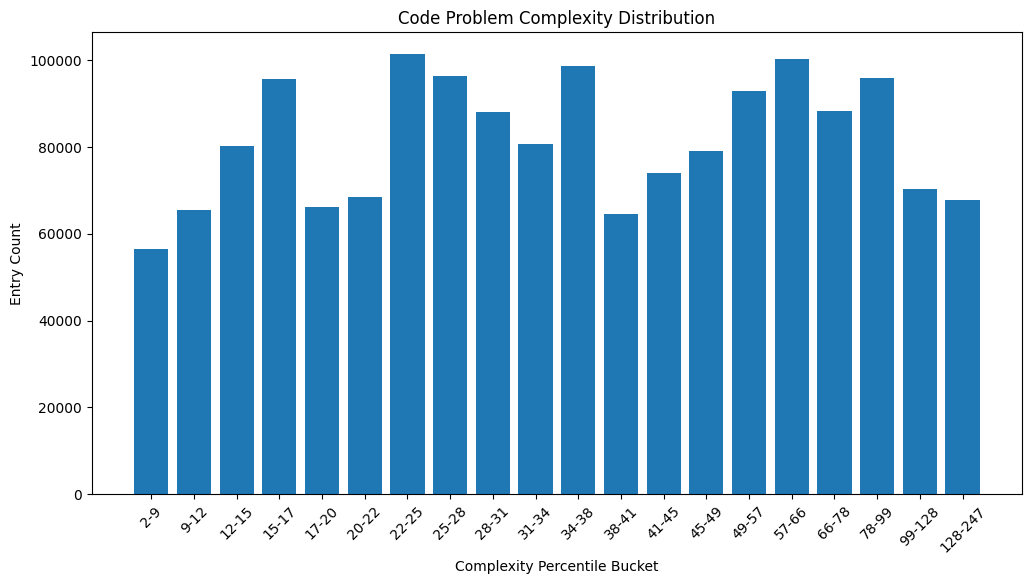

In [ ]:

def plot_complexity_distribution(distribution):
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(distribution['counts'])), distribution['counts'].values())
    plt.xlabel('Complexity Percentile Bucket')
    plt.ylabel('Entry Count')
    plt.title('Code Problem Complexity Distribution')
    plt.xticks(ticks=range(len(distribution['percentiles'])-1),
               labels=[f"{int(distribution['percentiles'][i])}-{int(distribution['percentiles'][i+1])}"
                       for i in range(len(distribution['percentiles'])-1)],
               rotation=45)
    plt.show()

plot_complexity_distribution(distribution)

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import json
import numpy as np
import os
from tqdm import tqdm

# 1. Embedding Generation with CodeBERT
def generate_code_embeddings(jsonl_path, embedding_path='embeddings.npy', batch_size=64, max_length=512, chunk_strategy="mean"):
    if os.path.exists(embedding_path):
        print(f"Loading existing embeddings from {embedding_path}")
        return np.load(embedding_path)

    # Add length tracking
    length_stats = {
        'total': 0,
        'chunked': 0,
        'max_length': 0
    }

    tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
    model = AutoModel.from_pretrained("microsoft/codebert-base").cuda()
    embeddings = []

    def num_rows(filepath):
        with open(filepath) as f:
            return sum(1 for _ in f)

    total = num_rows(jsonl_path)

    def process_code_chunk(batch):
        inputs = tokenizer(
            batch, return_tensors="pt", padding=True,
            truncation=True, max_length=max_length
        ).to('cuda')

        with torch.no_grad():
            outputs = model(**inputs)

        return torch.mean(outputs.last_hidden_state, dim=1).cpu()

    with open(jsonl_path) as f:
        for line in tqdm(f, desc="Generating embeddings", total=total):
            entry = json.loads(line)
            code = entry['code']

            # Track original length
            tokens = tokenizer.tokenize(code)
            length_stats['total'] += 1
            length_stats['max_length'] = max(length_stats['max_length'], len(tokens))

            if len(tokens) <= max_length:
                # Code fits within limit - process normally
                chunk_embeddings = process_code_chunk([code])
                embeddings.append(chunk_embeddings[0].numpy())
            else:
                # Code exceeds limit - use chunking
                length_stats['chunked'] += 1

                # Split into overlapping chunks with stride
                stride = max_length // 2
                chunk_inputs = []

                for i in range(0, len(tokens), stride):
                    chunk_tokens = tokens[i:i+max_length]
                    if len(chunk_tokens) < max_length // 4:  # Skip very small final chunks
                        continue
                    chunk_text = tokenizer.convert_tokens_to_string(chunk_tokens)
                    chunk_inputs.append(chunk_text)

                if not chunk_inputs:  # Ensure we have at least one chunk
                    chunk_inputs = [tokenizer.convert_tokens_to_string(tokens[:max_length])]

                # Process each chunk in batches
                all_chunk_embeddings = []
                for i in range(0, len(chunk_inputs), batch_size):
                    batch_chunks = chunk_inputs[i:i+batch_size]
                    batch_embs = process_code_chunk(batch_chunks)
                    all_chunk_embeddings.extend([emb for emb in batch_embs])

                # Aggregate the chunk embeddings
                all_chunk_embeddings = torch.stack(all_chunk_embeddings)
                if chunk_strategy == "mean":
                    final_embedding = torch.mean(all_chunk_embeddings, dim=0).numpy()
                elif chunk_strategy == "max":
                    final_embedding = torch.max(all_chunk_embeddings, dim=0)[0].numpy()
                else:  # Default to mean
                    final_embedding = torch.mean(all_chunk_embeddings, dim=0).numpy()

                embeddings.append(final_embedding)

    # Print chunking stats
    print("Chunking Report:\n",
          f"- Total samples: {length_stats['total']}\n",
          f"- Chunked samples: {length_stats['chunked']} ",
          f"({length_stats['chunked']/length_stats['total']:.1%})\n",
          f"- Max token length: {length_stats['max_length']}")

    embeddings = np.array(embeddings)
    np.save(embedding_path, embeddings)
    print(f"Saved embeddings to {embedding_path}")
    return embeddings

# 2. Dimensionality Reduction
def reduce_dimensions(embeddings, n_components=50):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(embeddings)

# 3. Clustering
def cluster_embeddings(reduced_embeddings, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(reduced_embeddings)

# 4. Visualization and Analysis
def analyze_clusters(reduced_embeddings, cluster_labels):
    # UMAP Visualization
    umap_embeddings = UMAP().fit_transform(reduced_embeddings)

    plt.figure(figsize=(12, 8))
    plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1],
                c=cluster_labels, cmap='Spectral', alpha=0.6)
    plt.colorbar()
    plt.title("Code Embedding Clusters")
    plt.show()

# 5. Academic Cluster Interpretation Methods
def interpret_clusters(jsonl_path, cluster_labels, n_samples=5):
    # Load data with clusters
    data = []
    with open(jsonl_path) as f:
        for i, line in enumerate(tqdm(f, desc="Loading data")):
            entry = json.loads(line)
            entry['cluster'] = cluster_labels[i]
            data.append(entry)

    df = pd.DataFrame(data)

    # Academic Analysis Techniques:
    for cluster_id in df['cluster'].unique():
        cluster_df = df[df['cluster'] == cluster_id]
        cluster_size = len(cluster_df)

        print(f"\nCluster {cluster_id} (Size: {cluster_size}) Characteristics:")

        # Handle small clusters
        sample_size = min(n_samples, cluster_size)
        replace = cluster_size < n_samples

        samples = cluster_df.sample(n=sample_size, replace=replace)['code']

        # b. Keyword Frequency Analysis
        from collections import Counter
        keywords = Counter()
        for code in samples:
            keywords.update(code.split())

        print("Top Keywords:", keywords.most_common(5))

        # c. Code Structure Analysis
        print("Sample Code Snippets:")
        for code in samples:
            print("-", code[:100] + "...")

# Full Pipeline
def analyze_code_dataset(jsonl_path,embedding_path):
    # 1. Generate embeddings
    embeddings = generate_code_embeddings(jsonl_path, embedding_path)

    # 2. Reduce dimensionality
    reduced_emb = reduce_dimensions(embeddings)

    # 3. Cluster data
    clusters = cluster_embeddings(reduced_emb)

    # 4. Visualize
    analyze_clusters(reduced_emb, clusters)

    # 5. Interpret clusters
    interpret_clusters(jsonl_path, clusters)

# Usage
# analyze_code_dataset(jsonl_path ='/content/drive/MyDrive/DL2/subset.jsonl', embedding_path='subset_embeddings.npy')

In [ ]:
# generate_code_embeddings(jsonl_path ='ast-pyedur_full.jsonl', embedding_path='all_embeddings.npy')

In [32]:
# embeddings = np.load('/content/drive/MyDrive/DL2/all_embeddings.npy')
embeddings = np.load('all_embeddings.npy')

In [33]:
import numpy as np
from sklearn.preprocessing import normalize

# Assuming `embeddings` is a numpy array of shape (n_samples, n_features)
normalized_embeddings = normalize(embeddings, norm='l2', axis=1)

In [34]:
# 2. Dimensionality Reduction
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def reduce_dimensions(embeddings, n_components=10, plot_variance=False):
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    
    # Get explained variance ratios
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    print(f"Explained variance by each component: {explained_variance}")
    print(f"Cumulative explained variance: {cumulative_variance}")
    
    # Optional: Plot the variance
    if plot_variance:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, n_components+1), cumulative_variance, marker='o')
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title("PCA Explained Variance")
        plt.grid()
        plt.show()
    
    return reduced_embeddings

Explained variance by each component: [0.2663236  0.20797318 0.11065899 0.0440102  0.03510777 0.02829361
 0.024458   0.02293255 0.01478187 0.01320335 0.01290017 0.01075785
 0.00883709 0.00763545 0.00642026]
Cumulative explained variance: [0.2663236  0.47429678 0.58495575 0.628966   0.66407377 0.6923674
 0.71682537 0.7397579  0.7545398  0.7677432  0.78064334 0.7914012
 0.8002383  0.8078738  0.81429404]


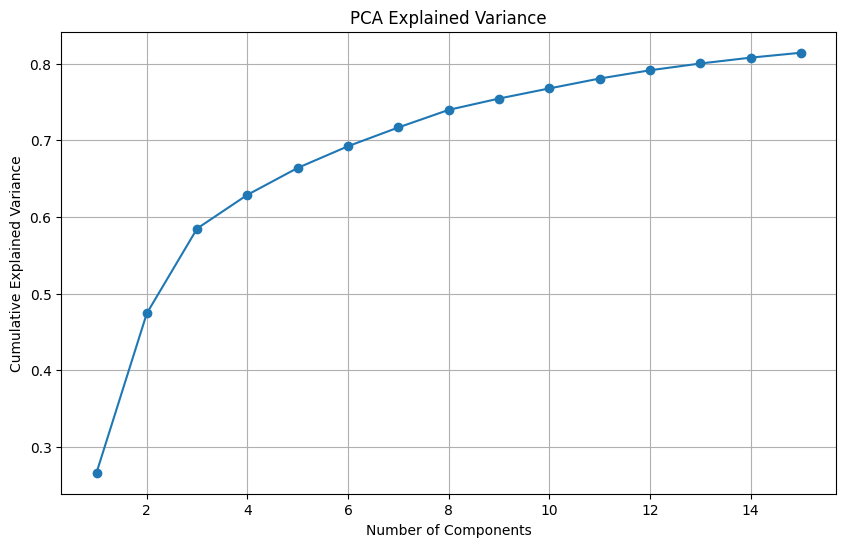

In [40]:
reduced_normalized_embeddings_15 = reduce_dimensions(normalized_embeddings,15, plot_variance = True)
# embeddings = torch.from_numpy(reduced_embeddings)

In [ ]:
# Analuyze clusters function
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from collections import Counter
import random

def analyze_clusters(reduced_embeddings, cluster_labels, n_clusters=6000):
    # 1. Check cluster distribution
    cluster_counts = Counter(cluster_labels)

    print(f"Total clusters: {n_clusters}")
    print(f"Non-empty clusters: {len(cluster_counts)}")
    print(f"Largest cluster: {max(cluster_counts.values())} points")
    print(f"Smallest cluster: {min(cluster_counts.values())} points")
    print(f"Average cluster size: {len(cluster_labels)/len(cluster_counts):.1f} points")

    # 2. Plot distribution of cluster sizes
    plt.figure(figsize=(12, 6))
    sizes = list(cluster_counts.values())
    plt.hist(sizes, bins=50)
    plt.title("Distribution of Cluster Sizes")
    plt.xlabel("Cluster Size")
    plt.ylabel("Count")
    plt.show()

    # 3. Sample and visualize a few random clusters
    sample_size = min(10, len(cluster_counts))
    random_clusters = random.sample(list(cluster_counts.keys()), sample_size)

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for i, cluster_id in enumerate(random_clusters):
        if i >= len(axes):
            break

        # Get points in this cluster
        mask = cluster_labels == cluster_id
        cluster_points = reduced_embeddings[mask]

        # If too many points, sample a subset
        if len(cluster_points) > 100:
            indices = np.random.choice(len(cluster_points), 100, replace=False)
            cluster_points = cluster_points[indices]

        # Calculate cluster center
        center = np.mean(cluster_points, axis=0)

        # Calculate distances from center
        distances = np.linalg.norm(cluster_points - center, axis=1)

        # Plot histogram of distances from center
        axes[i].hist(distances, bins=20)
        axes[i].set_title(f"Cluster {cluster_id}: {cluster_counts[cluster_id]} points")
        axes[i].set_xlabel("Distance from center")

    plt.tight_layout()
    plt.show()

    # 4. Compute clustering metrics on a sample if dataset is too large
    if len(reduced_embeddings) > 100000:
        sample_indices = np.random.choice(len(reduced_embeddings), 100000, replace=False)
        sample_data = reduced_embeddings[sample_indices]
        sample_labels = cluster_labels[sample_indices]

        print("Computing metrics on a sample of 100,000 points...")
        try:
            s_score = silhouette_score(sample_data, sample_labels, sample_size=10000)
            print(f"Silhouette Score: {s_score:.4f}")
        except:
            print("Silhouette score calculation failed (too many clusters)")

        try:
            ch_score = calinski_harabasz_score(sample_data, sample_labels)
            print(f"Calinski-Harabasz Score: {ch_score:.2f}")
        except:
            print("Calinski-Harabasz score calculation failed")
    else:
        try:
            s_score = silhouette_score(reduced_embeddings, cluster_labels, sample_size=10000)
            print(f"Silhouette Score: {s_score:.4f}")
        except:
            print("Silhouette score calculation failed (too many clusters)")

        try:
            ch_score = calinski_harabasz_score(reduced_embeddings, cluster_labels)
            print(f"Calinski-Harabasz Score: {ch_score:.2f}")
        except:
            print("Calinski-Harabasz score calculation failed")

# analyze_clusters(reduced_embeddings, mb_clusters)

In [11]:
from sklearn.cluster import HDBSCAN

# Create HDBSCAN clusterer with standard parameters
clusterer = HDBSCAN()

hdb_clusters = clusterer.fit_predict(reduced_normalized_embeddings)

# Access clustering results
labels_reduced10_normalized = clusterer.labels_          # Cluster labels (with -1 for noise points)
probabilities_reduced10_normalized = clusterer.probabilities_  # Cluster membership probabilities
np.save('hdbscan_labels_reduced10_normalized.npy', labels_reduced10_normalized)

# # Save the probabilities to a file
np.save('hdbscan_probabilities_reduced10_normalized.npy', probabilities_reduced10_normalized)

Number of points: 1630607
Number of clusters: 137260
Number of noise points: 5713 (0.35%)
Total clusters: 6000
Non-empty clusters: 137261
Largest cluster: 5713 points
Smallest cluster: 5 points
Average cluster size: 11.9 points


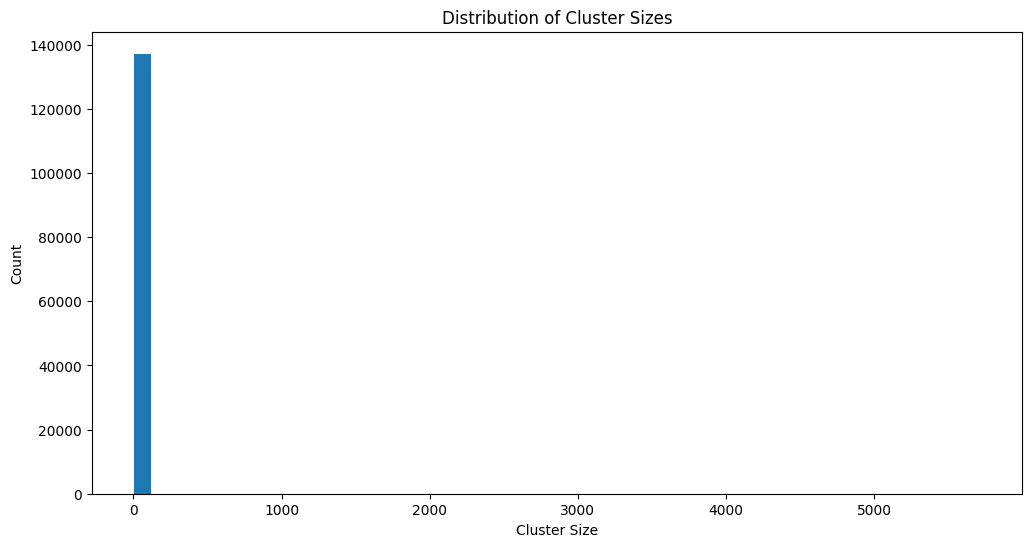

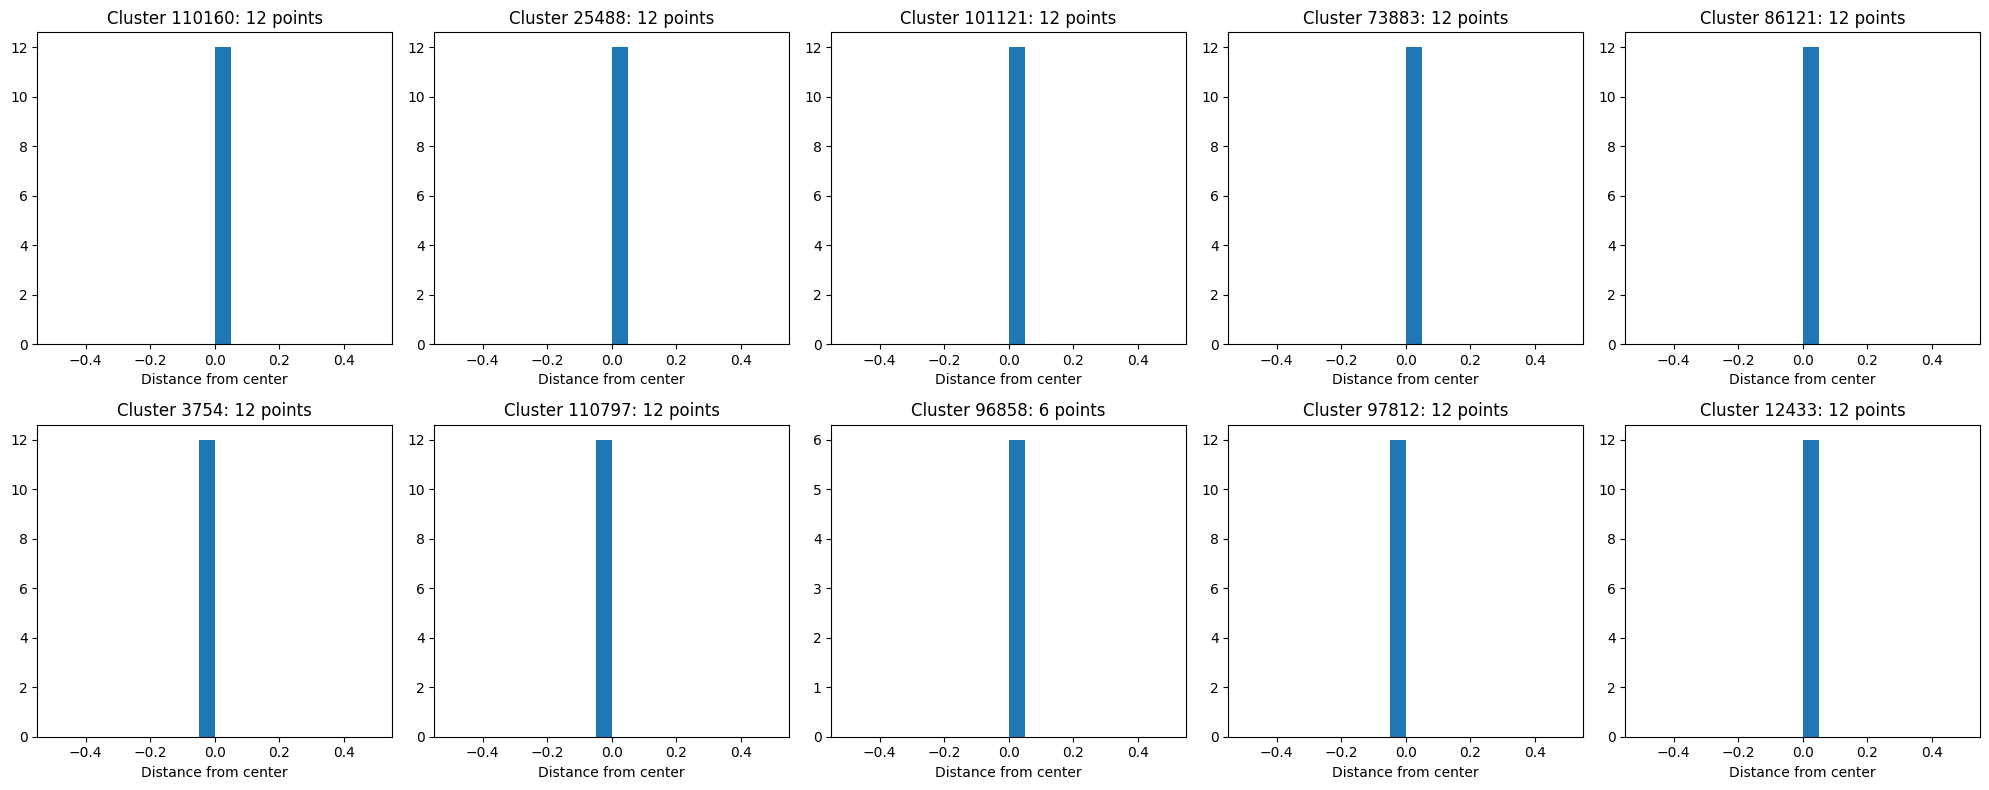

Computing metrics on a sample of 100,000 points...
Silhouette Score: 0.0603
Calinski-Harabasz Score: 115.53


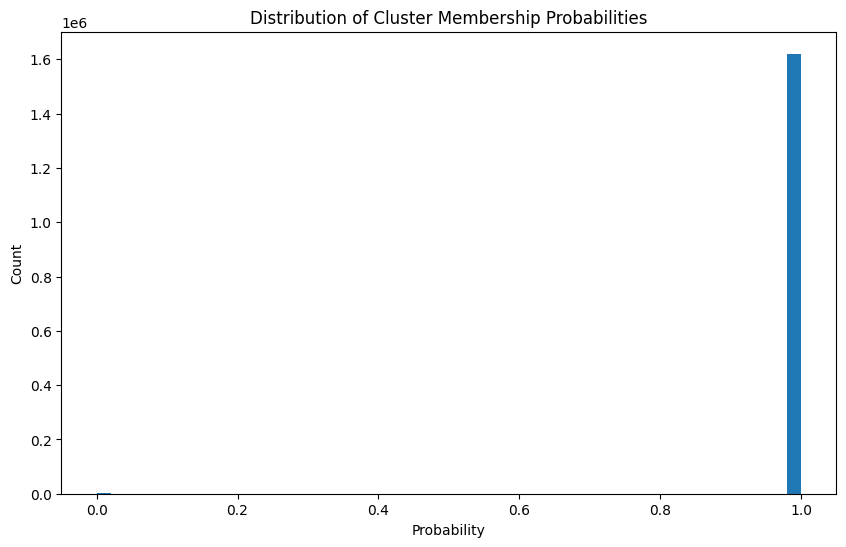

In [12]:
# First, let's see how many clusters HDBSCAN found
# First check what we have
print(f"Number of points: {len(labels_reduced10_normalized)}")
print(f"Number of clusters: {len(np.unique(labels_reduced10_normalized))-1}")  # -1 to exclude noise cluster
print(f"Number of noise points: {np.sum(labels_reduced10_normalized == -1)} ({np.sum(labels_reduced10_normalized == -1)/len(labels_reduced10_normalized):.2%})")

# Run the analysis function
analyze_clusters(reduced_normalized_embeddings, labels_reduced10_normalized)

# Analyze probabilities
plt.figure(figsize=(10, 6))
plt.hist(probabilities_reduced10_normalized[labels_reduced10_normalized != -1], bins=50)
plt.title("Distribution of Cluster Membership Probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

In [ ]:
import hdbscan
import numpy as np
from joblib import Memory
from time import time
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Create a memory cachedir
memory = Memory(location='./hdbscan_cache', verbose=1)

@memory.cache
def cached_hdbscan_fit(data, min_cluster_size, min_samples=None):
    """
    Cached version of HDBSCAN fitting using the standalone library
    """
    print(f"Computing HDBSCAN with min_cluster_size={min_cluster_size}, min_samples={min_samples}")
    start_time = time()
    
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric='euclidean',
        core_dist_n_jobs=-1,
        cluster_selection_method='eom'
    )
    
    labels = clusterer.fit_predict(data)
    
    print(f"Computation took {time() - start_time:.2f} seconds")
    return clusterer, labels

def calculate_clustering_metrics(data, labels):
    """
    Calculate clustering quality metrics
    """
    # Filter out noise points for metric calculation
    mask = labels != -1
    if len(np.unique(labels[mask])) < 2:
        return {
            'silhouette': None,
            'calinski_harabasz': None,
            'davies_bouldin': None
        }
    
    try:
        # Use sample for silhouette score if dataset is large
        if len(data) > 10000:
            silhouette = silhouette_score(data[mask], labels[mask], sample_size=10000, random_state=42)
        else:
            silhouette = silhouette_score(data[mask], labels[mask])
            
        calinski = calinski_harabasz_score(data[mask], labels[mask])
        davies = davies_bouldin_score(data[mask], labels[mask])
        
        return {
            'silhouette': silhouette,
            'calinski_harabasz': calinski,
            'davies_bouldin': davies
        }
    except Exception as e:
        print(f"Error calculating metrics: {str(e)}")
        return {
            'silhouette': None,
            'calinski_harabasz': None,
            'davies_bouldin': None
        }

def print_clustering_stats(data, labels, include_metrics=True):
    """
    Print statistics about the clustering results
    """
    n_clusters = len(np.unique(labels)) - 1  # -1 for noise
    noise_points = np.sum(labels == -1)
    noise_ratio = noise_points / len(labels)

    print(f"\nClustering Statistics:")
    print(f"Number of clusters: {n_clusters}")
    print(f"Noise points: {noise_points} ({noise_ratio:.2%})")
    if n_clusters > 0:
        cluster_sizes = [np.sum(labels == i) for i in range(n_clusters)]
        print(f"Largest cluster: {max(cluster_sizes)} points")
        print(f"Smallest cluster: {min(cluster_sizes)} points")
        print(f"Average cluster size: {np.mean(cluster_sizes):.1f} points")
        
        if include_metrics:
            metrics = calculate_clustering_metrics(data, labels)
            print("\nClustering Quality Metrics:")
            print(f"Silhouette Score (-1 to 1, higher is better): {metrics['silhouette']:.3f if metrics['silhouette'] is not None else 'N/A'}")
            print(f"Calinski-Harabasz Score (higher is better): {metrics['calinski_harabasz']:.1f if metrics['calinski_harabasz'] is not None else 'N/A'}")
            print(f"Davies-Bouldin Score (lower is better): {metrics['davies_bouldin']:.3f if metrics['davies_bouldin'] is not None else 'N/A'}")
    print("-" * 50)

# Initial run with min_cluster_size=20
print("Running initial clustering with min_cluster_size=20...")
clusterer, labels_reduced15_normalized = cached_hdbscan_fit(
    reduced_normalized_embeddings_15, 
    min_cluster_size=20
)

# Get probabilities
probabilities_reduced15_normalized = clusterer.probabilities_

# Save the results
np.save('hdbscan_labels_reduced15_normalized.npy', labels_reduced15_normalized)
np.save('hdbscan_probabilities_reduced15_normalized.npy', probabilities_reduced15_normalized)

# Print statistics with metrics
print_clustering_stats(reduced_normalized_embeddings_15, labels_reduced15_normalized)

def test_different_parameters():
    """
    Function to test different parameter combinations
    The computation will be cached, so subsequent runs will be faster
    """
    param_combinations = [
        {'min_cluster_size': 20, 'min_samples': None},
        {'min_cluster_size': 50, 'min_samples': None},
        {'min_cluster_size': 100, 'min_samples': None},
        {'min_cluster_size': 200, 'min_samples': None}
    ]
    
    results = {}
    for params in param_combinations:
        print(f"\nTesting parameters: {params}")
        clusterer, labels = cached_hdbscan_fit(
            reduced_normalized_embeddings_15,
            min_cluster_size=params['min_cluster_size'],
            min_samples=params['min_samples']
        )
        results[f"mcs_{params['min_cluster_size']}"] = {
            'labels': labels,
            'probabilities': clusterer.probabilities_,
            'metrics': calculate_clustering_metrics(reduced_normalized_embeddings_15, labels)
        }
        print_clustering_stats(reduced_normalized_embeddings_15, labels)
    
    return results

# Uncomment to test different parameters
# results = test_different_parameters()

Running initial clustering with min_cluster_size=20...
________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-Oliver-AppData-Local-Temp-ipykernel-2563248851.cached_hdbscan_fit...
cached_hdbscan_fit(array([[-0.063863, ..., -0.035991],
       ...,
       [-0.003731, ..., -0.017996]], shape=(1630607, 15), dtype=float32), min_cluster_size=20)
Computing HDBSCAN with min_cluster_size=20, min_samples=None


In [ ]:
results = test_different_parameters()

In [ ]:
# Test combinations including defaults and gradual increases
param_combinations = [
    # Default parameters
    {'min_cluster_size': 5, 'min_samples': None},
    
    # Slightly increased from default
    {'min_cluster_size': 10, 'min_samples': None},
    {'min_cluster_size': 20, 'min_samples': None},
    
    # Medium values
    {'min_cluster_size': 50, 'min_samples': None},
    {'min_cluster_size': 50, 'min_samples': 10},
    
    # Larger values
    {'min_cluster_size': 100, 'min_samples': None},
    {'min_cluster_size': 100, 'min_samples': 20},
    
    # Very large values
    {'min_cluster_size': 500, 'min_samples': 50},
    {'min_cluster_size': 1000, 'min_samples': 100}
]


# Store results with metrics
results = {}

# Run tests with progress bar
print("Testing parameter combinations on sample data...")
for params in tqdm(param_combinations):
    key = f"mcs_{params['min_cluster_size']}_ms_{params['min_samples']}"
    labels, metrics = test_hdbscan_params(sample_data, **params)
    results[key] = {
        'labels': labels,
        'metrics': metrics,
        'params': params
    }

# Analyze and compare results
print("\nSummary of Best Parameters:")
metric_rankings = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': [],
    'relative_validity': []
}

for key, result in results.items():
    metrics = result['metrics']
    if metrics['silhouette'] is not None:
        metric_rankings['silhouette'].append((metrics['silhouette'], key))
    if metrics['calinski_harabasz'] is not None:
        metric_rankings['calinski_harabasz'].append((metrics['calinski_harabasz'], key))
    if metrics['davies_bouldin'] is not None:
        metric_rankings['davies_bouldin'].append((metrics['davies_bouldin'], key))
    if metrics['relative_validity'] is not None:
        metric_rankings['relative_validity'].append((metrics['relative_validity'], key))

print("\nBest parameters according to different metrics:")
print("\nSilhouette Score (higher is better):")
for score, key in sorted(metric_rankings['silhouette'], reverse=True)[:3]:
    print(f"{key}: {score:.3f}")

print("\nCalinski-Harabasz Score (higher is better):")
for score, key in sorted(metric_rankings['calinski_harabasz'], reverse=True)[:3]:
    print(f"{key}: {score:.1f}")

print("\nDavies-Bouldin Score (lower is better):")
for score, key in sorted(metric_rankings['davies_bouldin'])[:3]:
    print(f"{key}: {score:.3f}")

print("\nHDBSCAN Relative Validity (higher is better):")
for score, key in sorted(metric_rankings['relative_validity'], reverse=True)[:3]:
    print(f"{key}: {score:.3f}")

Testing parameter combinations on sample data...


  0%|          | 0/9 [00:00<?, ?it/s]


Results for min_cluster_size=5, min_samples=None
Number of points: 100000
Number of clusters: 1590
Noise points: 86445 (86.45%)
Largest cluster: 86 points
Smallest cluster: 5 points
Average cluster size: 8.5 points


 11%|█         | 1/9 [00:44<05:54, 44.31s/it]


Clustering Quality Metrics:
Silhouette Score: 0.37357276678085327
Calinski-Harabasz Score: 402.5882263183594
Davies-Bouldin Score: 0.9666610171543911
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=10, min_samples=None
Number of points: 100000
Number of clusters: 48
Noise points: 74914 (74.91%)
Largest cluster: 23916 points
Smallest cluster: 10 points
Average cluster size: 522.6 points


 22%|██▏       | 2/9 [01:24<04:51, 41.69s/it]


Clustering Quality Metrics:
Silhouette Score: -0.07292983680963516
Calinski-Harabasz Score: 167.57870483398438
Davies-Bouldin Score: 0.8832403113709612
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=20, min_samples=None
Number of points: 100000
Number of clusters: 2
Noise points: 23064 (23.06%)
Largest cluster: 76909 points
Smallest cluster: 27 points
Average cluster size: 38468.0 points


 33%|███▎      | 3/9 [02:02<04:02, 40.38s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5385400652885437
Calinski-Harabasz Score: 213.904296875
Davies-Bouldin Score: 0.41194302623946516
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=50, min_samples=None
Number of points: 100000
Number of clusters: 2
Noise points: 56673 (56.67%)
Largest cluster: 42984 points
Smallest cluster: 343 points
Average cluster size: 21663.5 points


 44%|████▍     | 4/9 [02:41<03:17, 39.56s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5393354296684265
Calinski-Harabasz Score: 2554.130859375
Davies-Bouldin Score: 0.48191837142396365
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=50, min_samples=10
Number of points: 100000
Number of clusters: 2
Noise points: 18623 (18.62%)
Largest cluster: 81326 points
Smallest cluster: 51 points
Average cluster size: 40688.5 points


 56%|█████▌    | 5/9 [03:20<02:38, 39.50s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5160714387893677
Calinski-Harabasz Score: 373.5559997558594
Davies-Bouldin Score: 0.4593791508810631
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=100, min_samples=None
Number of points: 100000
Number of clusters: 2
Noise points: 56834 (56.83%)
Largest cluster: 42941 points
Smallest cluster: 225 points
Average cluster size: 21583.0 points


 67%|██████▋   | 6/9 [04:00<01:59, 39.76s/it]


Clustering Quality Metrics:
Silhouette Score: 0.540977418422699
Calinski-Harabasz Score: 1670.1837158203125
Davies-Bouldin Score: 0.4478271179527509
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=100, min_samples=20
Number of points: 100000
Number of clusters: 2
Noise points: 61676 (61.68%)
Largest cluster: 37819 points
Smallest cluster: 505 points
Average cluster size: 19162.0 points


 78%|███████▊  | 7/9 [04:40<01:19, 39.54s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5340943336486816
Calinski-Harabasz Score: 3448.697021484375
Davies-Bouldin Score: 0.5865703040962778
HDBSCAN Relative Validity: None
--------------------------------------------------


 89%|████████▉ | 8/9 [05:19<00:39, 39.47s/it]


Results for min_cluster_size=500, min_samples=50
Number of points: 100000
Number of clusters: 0
Noise points: 100000 (100.00%)

Clustering Quality Metrics:
Silhouette Score: None
Calinski-Harabasz Score: None
Davies-Bouldin Score: None
HDBSCAN Relative Validity: None
--------------------------------------------------


100%|██████████| 9/9 [06:00<00:00, 40.10s/it]


Results for min_cluster_size=1000, min_samples=100
Number of points: 100000
Number of clusters: 0
Noise points: 100000 (100.00%)

Clustering Quality Metrics:
Silhouette Score: None
Calinski-Harabasz Score: None
Davies-Bouldin Score: None
HDBSCAN Relative Validity: None
--------------------------------------------------

Summary of Best Parameters:

Best parameters according to different metrics:

Silhouette Score (higher is better):
mcs_100_ms_None: 0.541
mcs_50_ms_None: 0.539
mcs_20_ms_None: 0.539

Calinski-Harabasz Score (higher is better):
mcs_100_ms_20: 3448.7
mcs_50_ms_None: 2554.1
mcs_100_ms_None: 1670.2

Davies-Bouldin Score (lower is better):
mcs_20_ms_None: 0.412
mcs_100_ms_None: 0.448
mcs_50_ms_10: 0.459

HDBSCAN Relative Validity (higher is better):


## Go away for now

In [20]:
np.save('hdbscan_labels_2.npy', labels)

# # Save the probabilities to a file
np.save('hdbscan_probabilities_2.npy', probabilities)

In [5]:

# # Save the cluster labels to a file
# np.save('hdbscan_labels.npy', labels)

# # Save the probabilities to a file
# np.save('hdbscan_probabilities.npy', probabilities)

# To load them later:
loaded_labels = np.load('hdbscan_labels.npy')
loaded_probabilities = np.load('hdbscan_probabilities.npy')

In [ ]:
np.save('hdbscan_labels_reduced10_normalized.npy', labels_reduced10_normalized)

# # Save the probabilities to a file
np.save('hdbscan_probabilities_reduced10_normalized.npy', probabilities_reduced10_normalized)

Number of points: 1630607
Number of clusters: 137263
Number of noise points: 5905 (0.36%)
Total clusters: 6000
Non-empty clusters: 137264
Largest cluster: 5905 points
Smallest cluster: 5 points
Average cluster size: 11.9 points


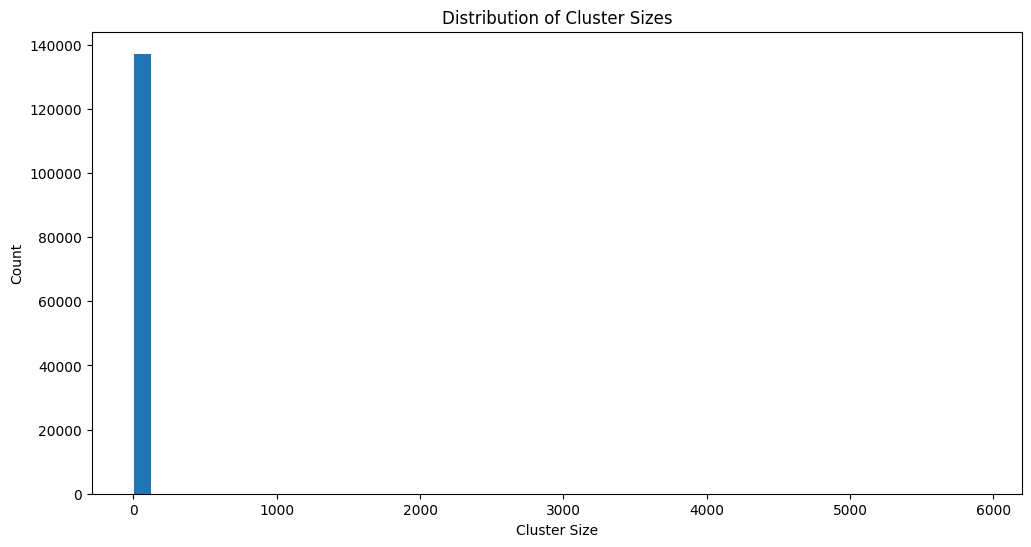

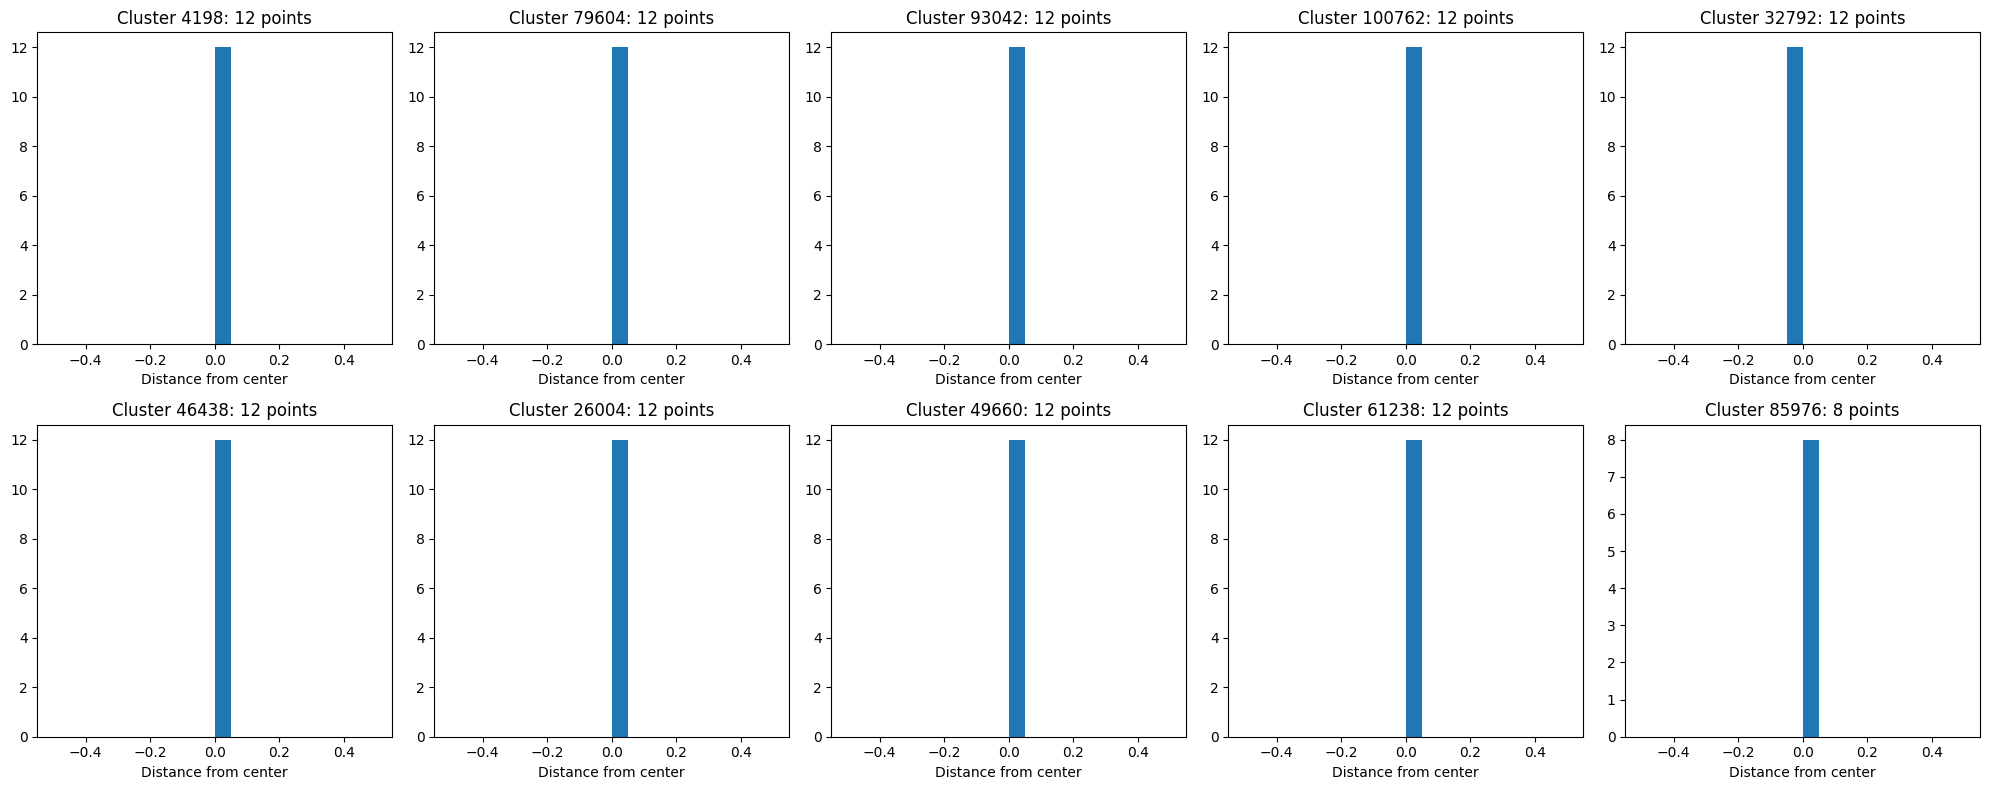

Computing metrics on a sample of 100,000 points...
Silhouette Score: 0.0664
Calinski-Harabasz Score: 105.31


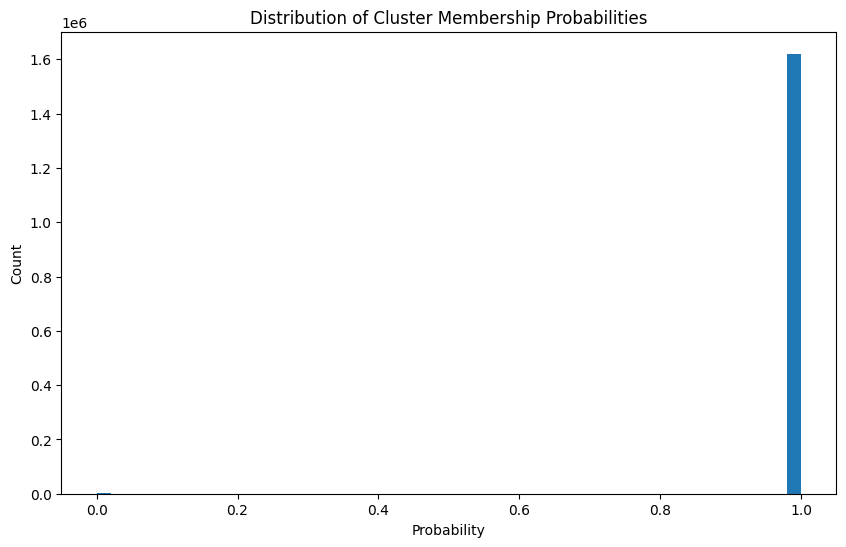

In [23]:
# First, let's see how many clusters HDBSCAN found
# First check what we have
print(f"Number of points: {len(labels)}")
print(f"Number of clusters: {len(np.unique(labels))-1}")  # -1 to exclude noise cluster
print(f"Number of noise points: {np.sum(labels == -1)} ({np.sum(labels == -1)/len(labels):.2%})")

# Run the analysis function
analyze_clusters(reduced_embeddings, labels)

# Analyze probabilities
plt.figure(figsize=(10, 6))
plt.hist(probabilities[labels != -1], bins=50)
plt.title("Distribution of Cluster Membership Probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

In [ ]:
np.save('hdbscan_labels_reduced10_normalized.npy', labels_reduced10_normalized)

# # Save the probabilities to a file
np.save('hdbscan_probabilities_reduced10_normalized.npy', probabilities_reduced10_normalized)

In [ ]:
np.save('hdbscan_labels_reduced10_normalized.npy', labels_reduced10_normalized)

# # Save the probabilities to a file
np.save('hdbscan_probabilities_reduced10_normalized.npy', probabilities_reduced10_normalized)

Number of points: 1630607
Number of clusters: 137250
Number of noise points: 5928 (0.36%)
Total clusters: 6000
Non-empty clusters: 137251
Largest cluster: 5928 points
Smallest cluster: 5 points
Average cluster size: 11.9 points


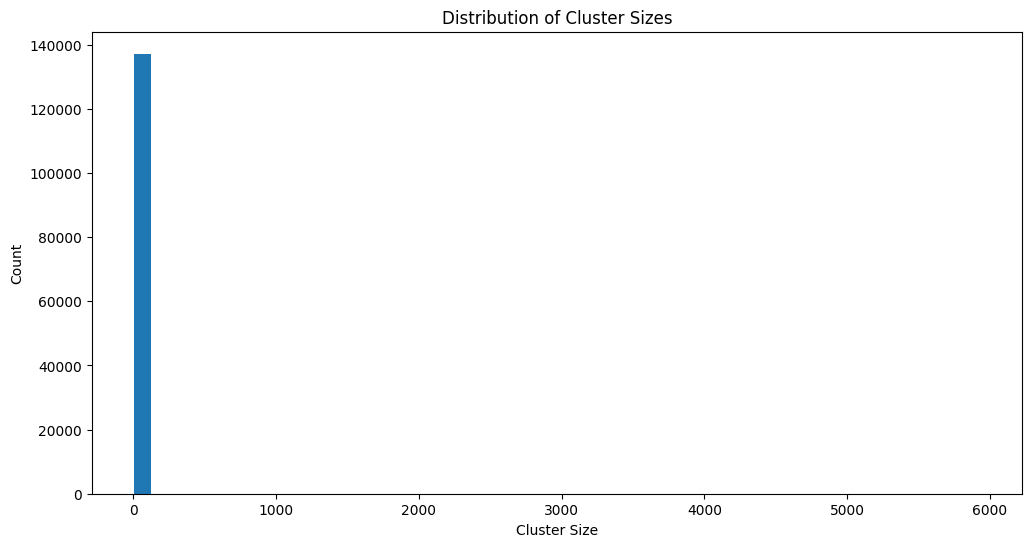

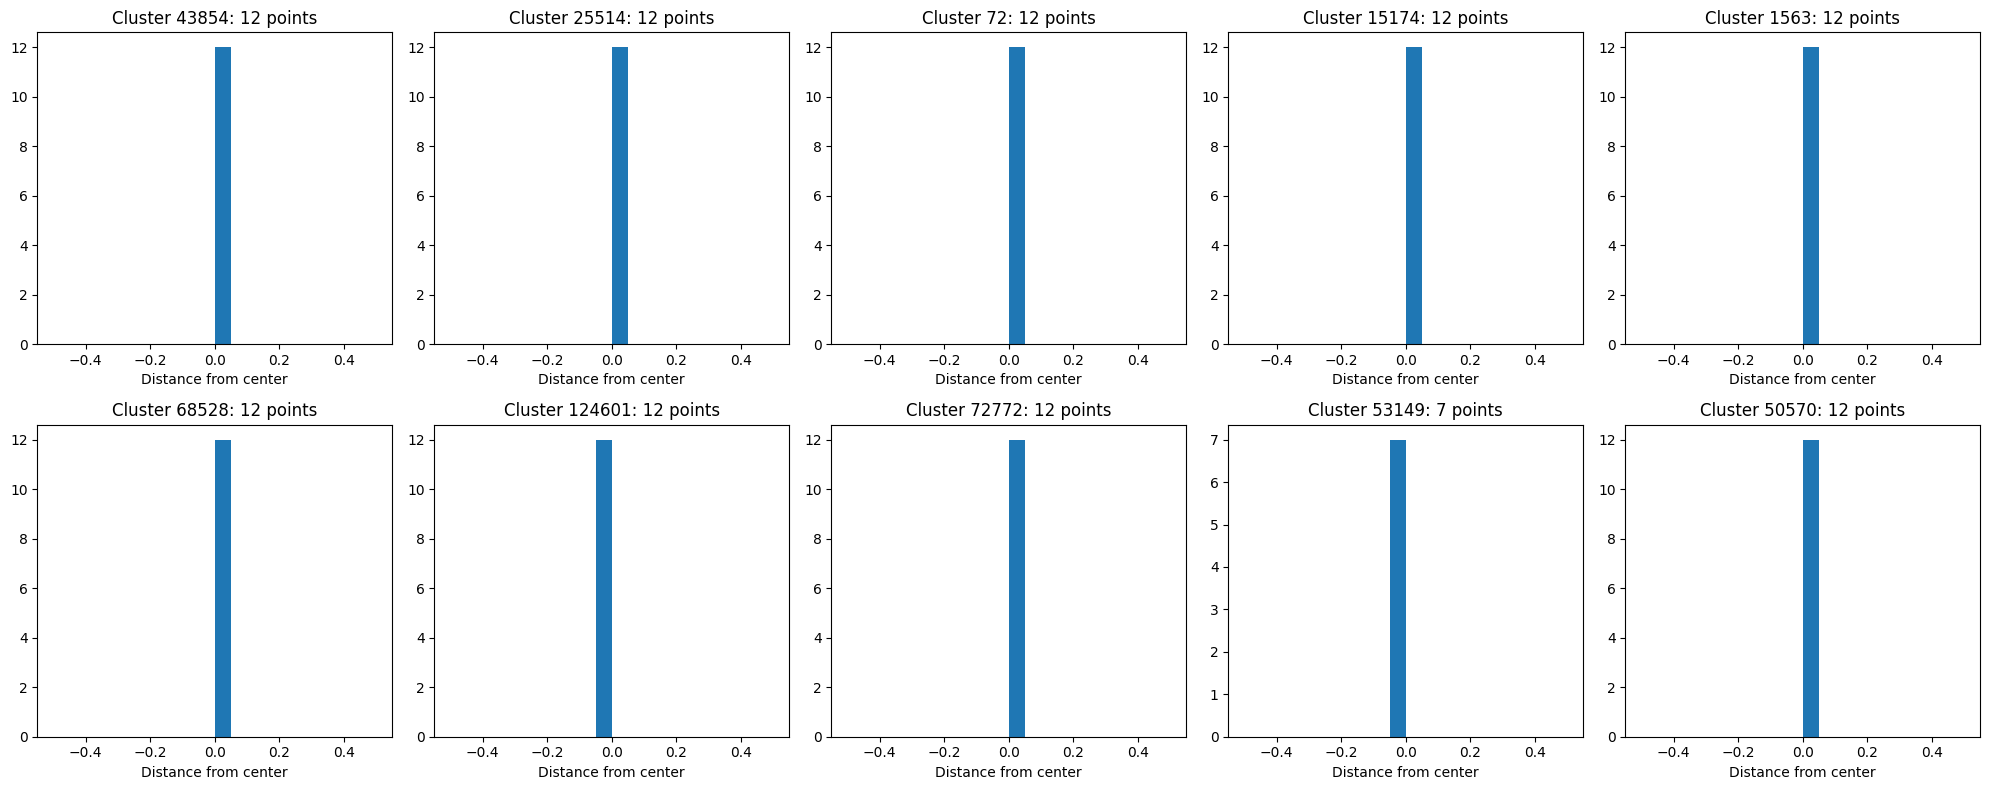

Computing metrics on a sample of 100,000 points...
Silhouette Score: 0.0639
Calinski-Harabasz Score: 115.11


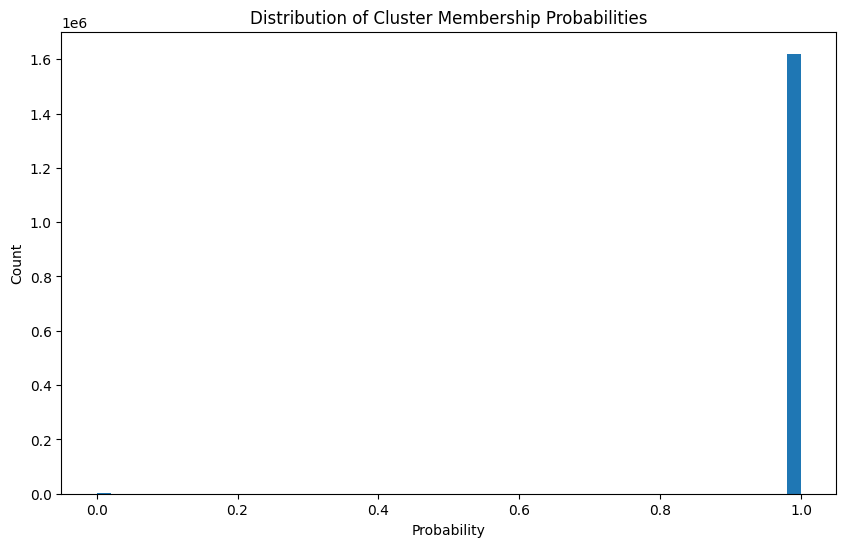

In [ ]:
# First, let's see how many clusters HDBSCAN found
# First check what we have
print(f"Number of points: {len(loaded_labels)}")
print(f"Number of clusters: {len(np.unique(loaded_labels))-1}")  # -1 to exclude noise cluster
print(f"Number of noise points: {np.sum(loaded_labels == -1)} ({np.sum(loaded_labels == -1)/len(loaded_labels):.2%})")

# Run the analysis function
analyze_clusters(reduced_embeddings, loaded_labels)

# Analyze probabilities
plt.figure(figsize=(10, 6))
plt.hist(loaded_probabilities[loaded_labels != -1], bins=50)
plt.title("Distribution of Cluster Membership Probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

Number of points: 1630607
Number of clusters: 137250
Number of noise points: 5928 (0.36%)
Total clusters: 6000
Non-empty clusters: 137251
Largest cluster: 5928 points
Smallest cluster: 5 points
Average cluster size: 11.9 points


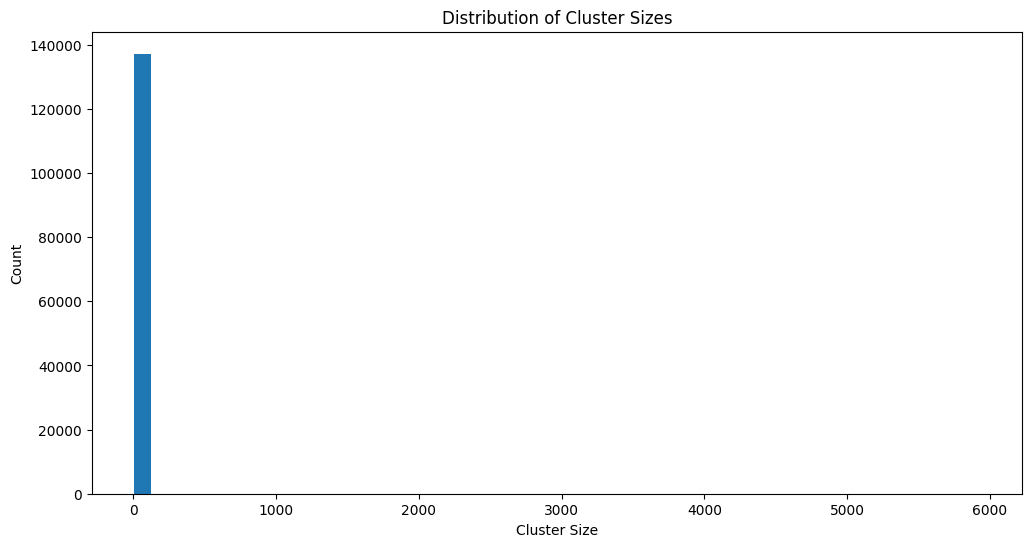

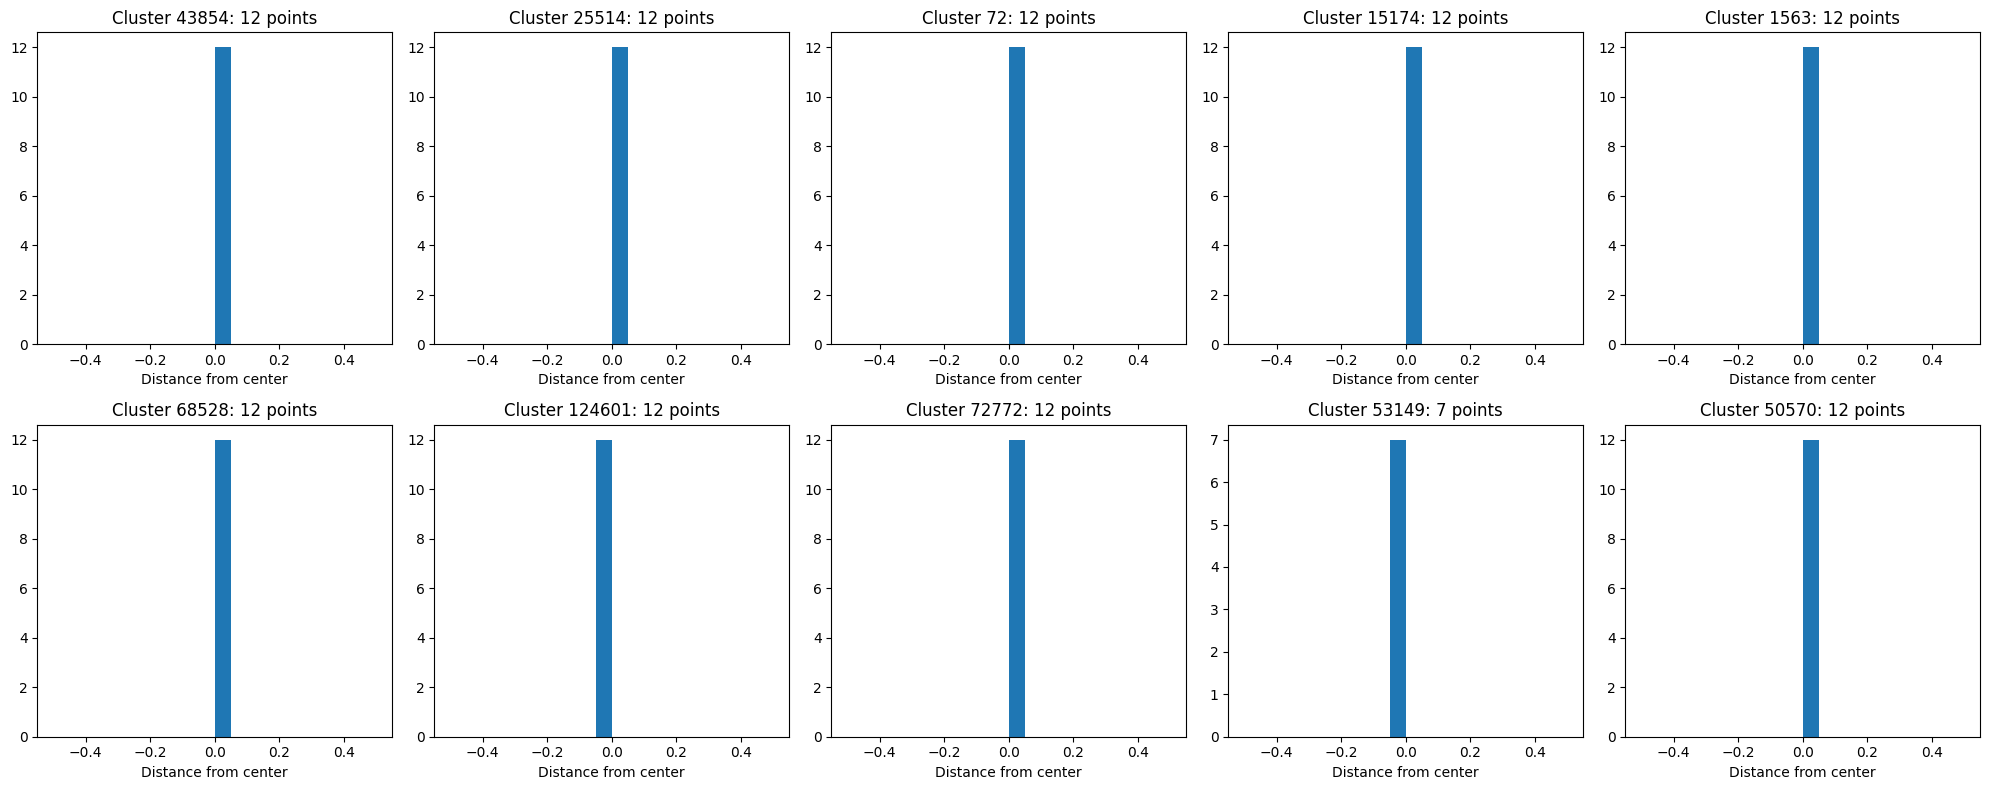

Computing metrics on a sample of 100,000 points...
Silhouette Score: 0.0639
Calinski-Harabasz Score: 115.11


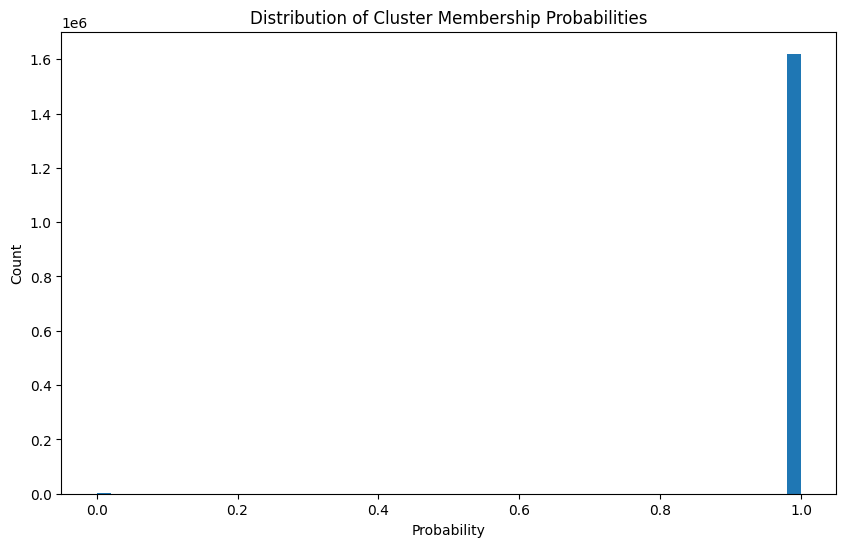

In [ ]:
# First, let's see how many clusters HDBSCAN found
# First check what we have
print(f"Number of points: {len(loaded_labels)}")
print(f"Number of clusters: {len(np.unique(loaded_labels))-1}")  # -1 to exclude noise cluster
print(f"Number of noise points: {np.sum(loaded_labels == -1)} ({np.sum(loaded_labels == -1)/len(loaded_labels):.2%})")

# Run the analysis function
analyze_clusters(reduced_embeddings, loaded_labels)

# Analyze probabilities
plt.figure(figsize=(10, 6))
plt.hist(loaded_probabilities[loaded_labels != -1], bins=50)
plt.title("Distribution of Cluster Membership Probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

Number of points: 1630607
Number of clusters: 137250
Number of noise points: 5928 (0.36%)
Total clusters: 6000
Non-empty clusters: 137251
Largest cluster: 5928 points
Smallest cluster: 5 points
Average cluster size: 11.9 points


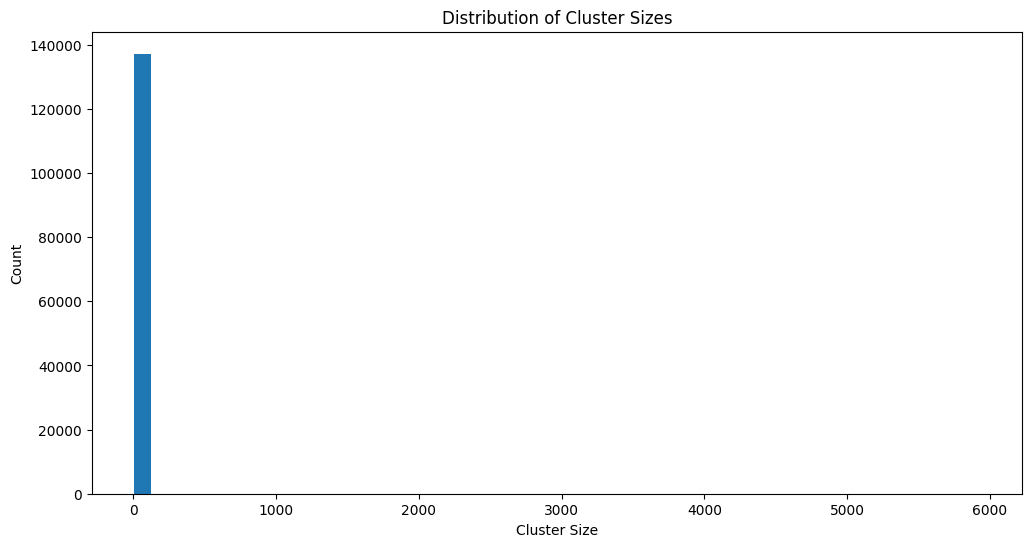

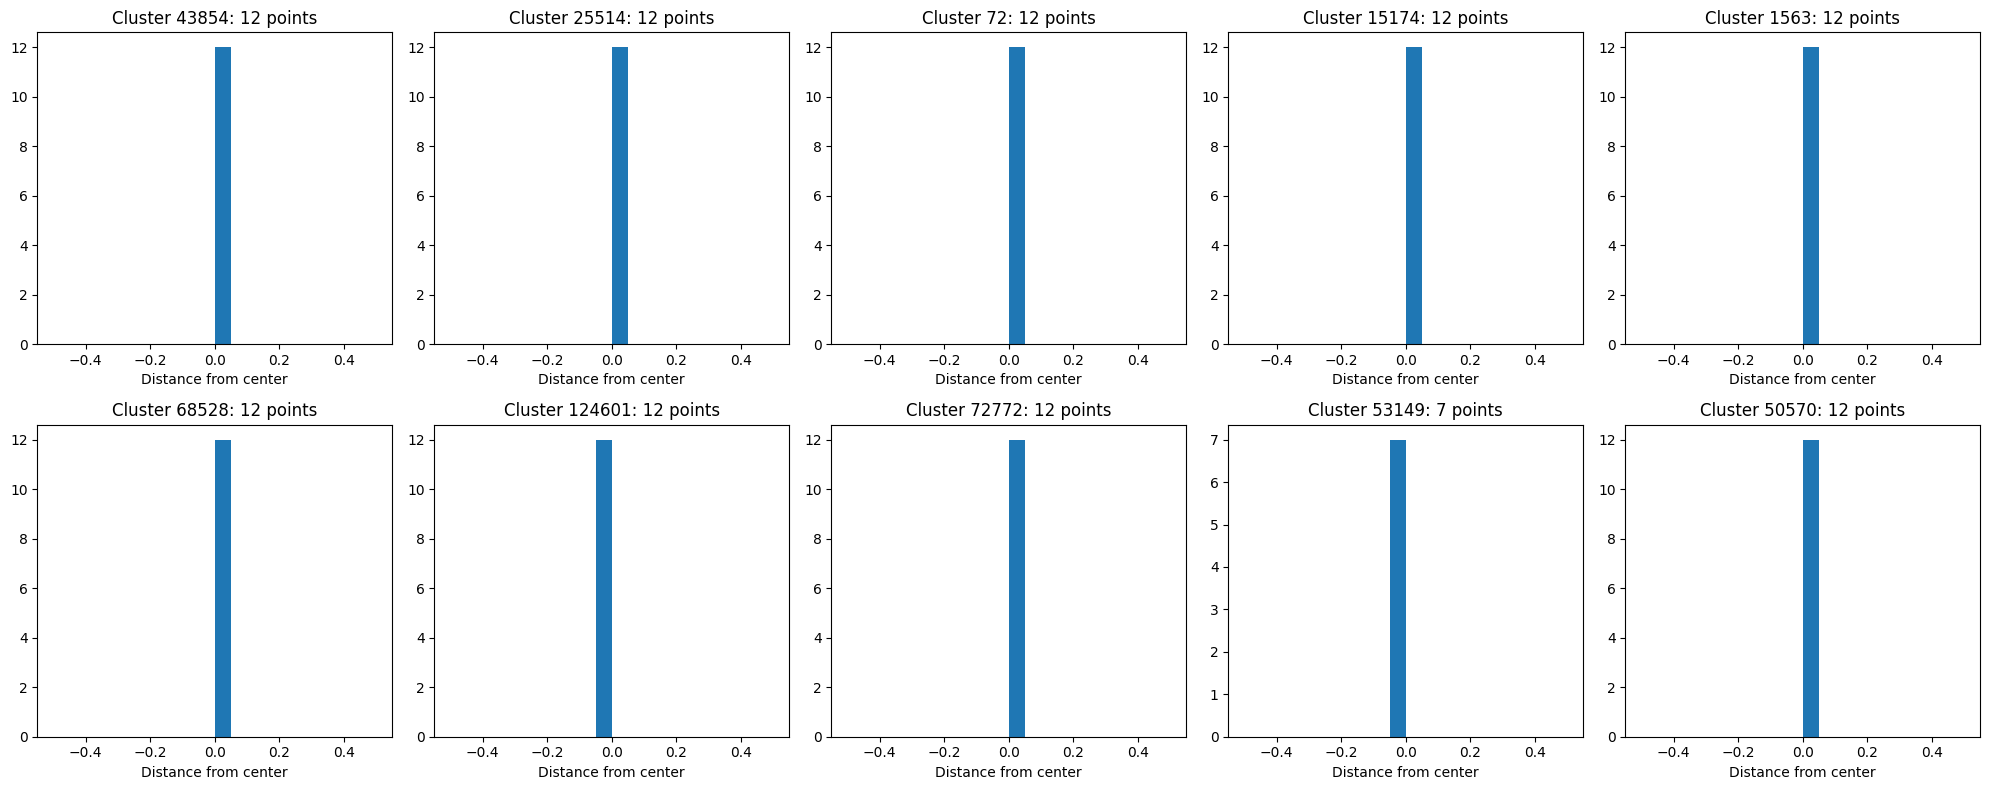

Computing metrics on a sample of 100,000 points...
Silhouette Score: 0.0639
Calinski-Harabasz Score: 115.11


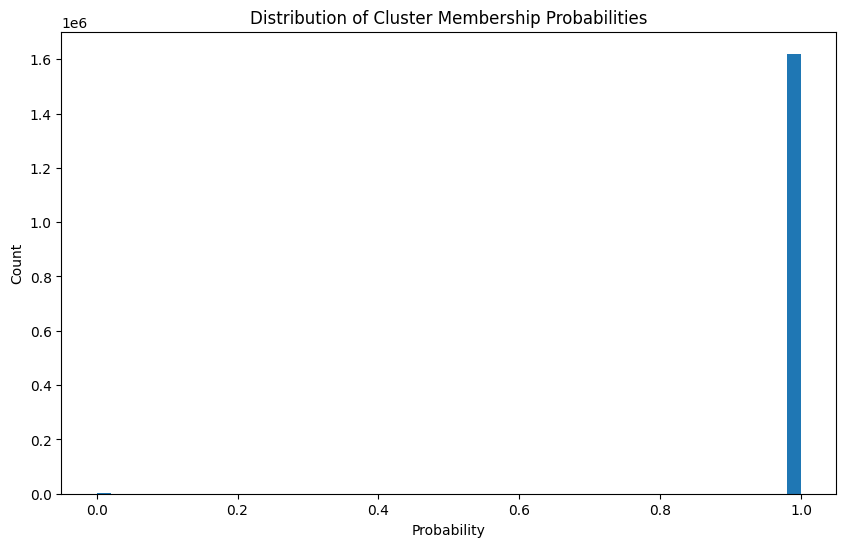

In [ ]:
# First, let's see how many clusters HDBSCAN found
# First check what we have
print(f"Number of points: {len(loaded_labels)}")
print(f"Number of clusters: {len(np.unique(loaded_labels))-1}")  # -1 to exclude noise cluster
print(f"Number of noise points: {np.sum(loaded_labels == -1)} ({np.sum(loaded_labels == -1)/len(loaded_labels):.2%})")

# Run the analysis function
analyze_clusters(reduced_embeddings, loaded_labels)

# Analyze probabilities
plt.figure(figsize=(10, 6))
plt.hist(loaded_probabilities[loaded_labels != -1], bins=50)
plt.title("Distribution of Cluster Membership Probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

Number of points: 1630607
Number of clusters: 137250
Number of noise points: 5928 (0.36%)
Total clusters: 6000
Non-empty clusters: 137251
Largest cluster: 5928 points
Smallest cluster: 5 points
Average cluster size: 11.9 points


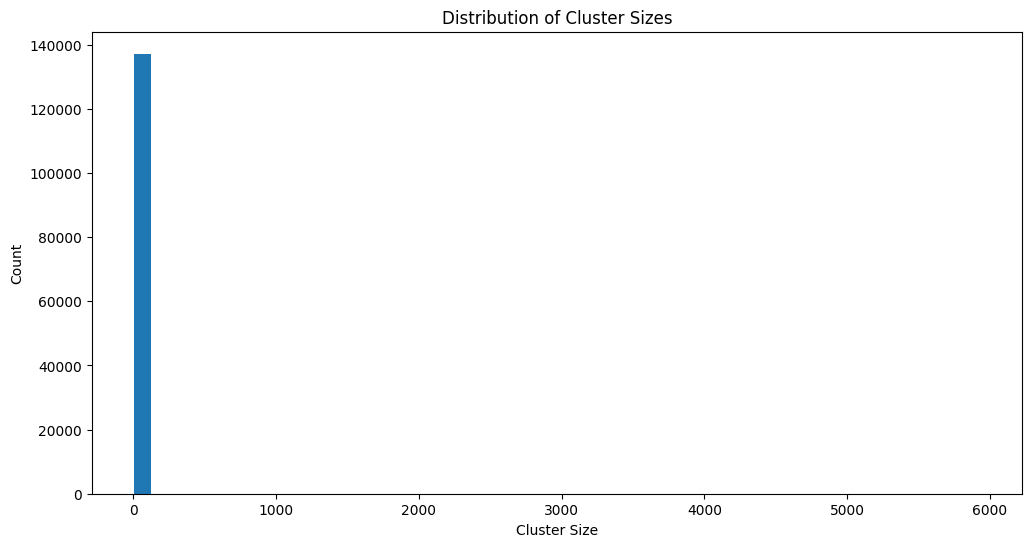

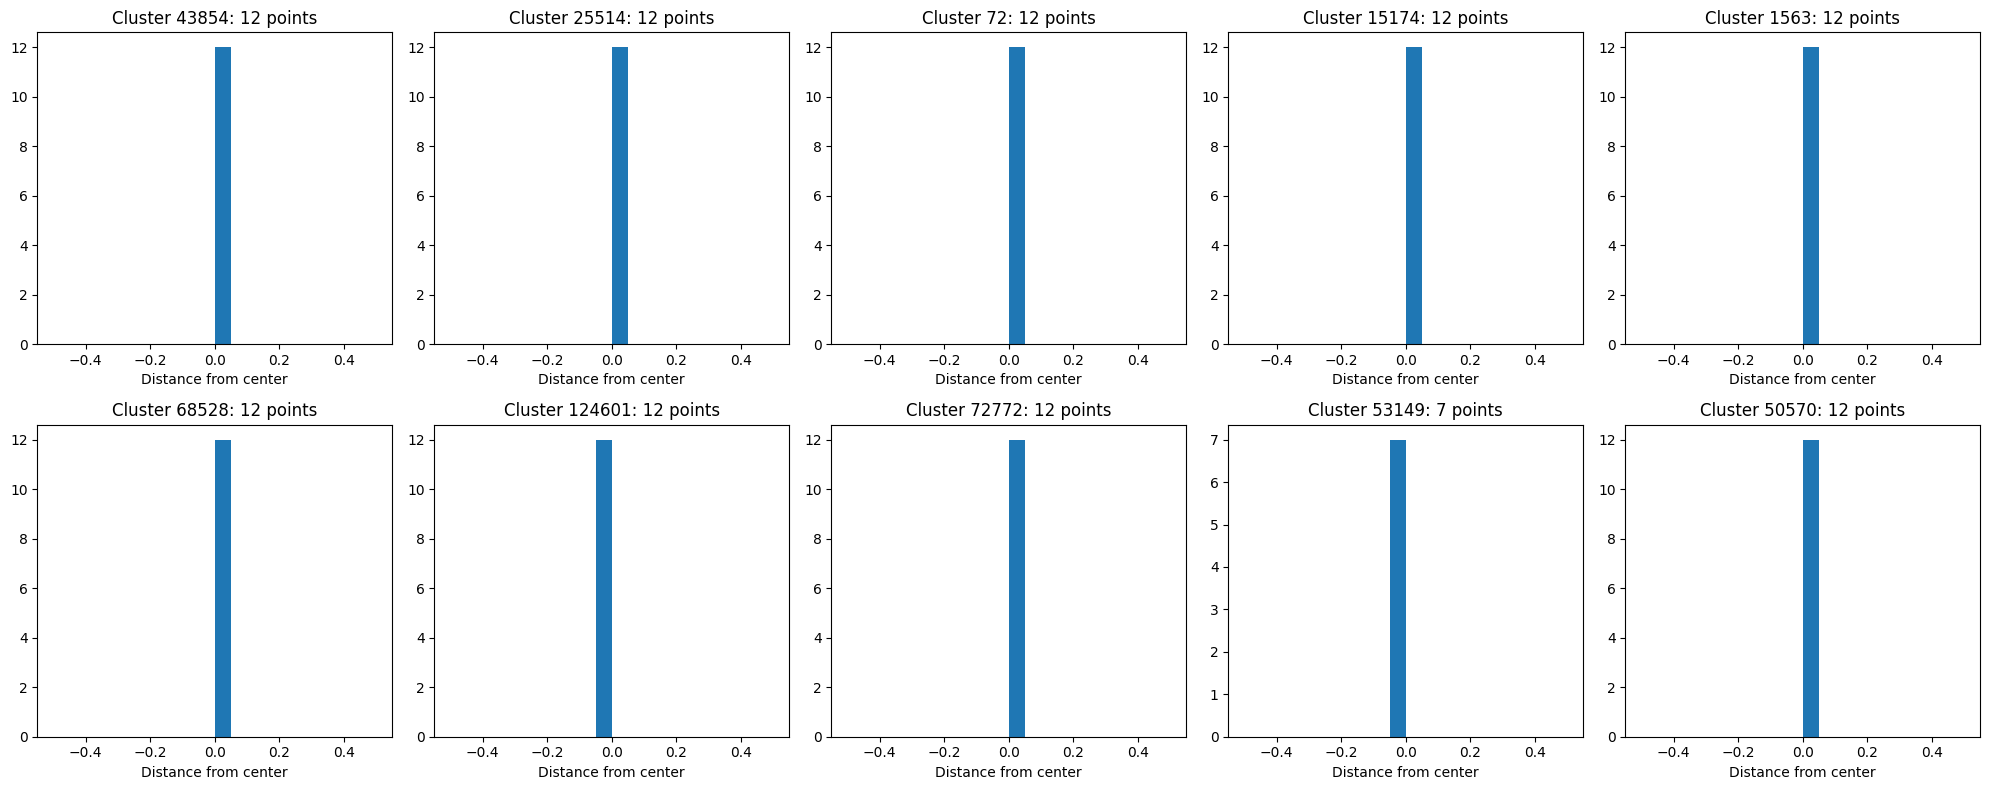

Computing metrics on a sample of 100,000 points...
Silhouette Score: 0.0639
Calinski-Harabasz Score: 115.11


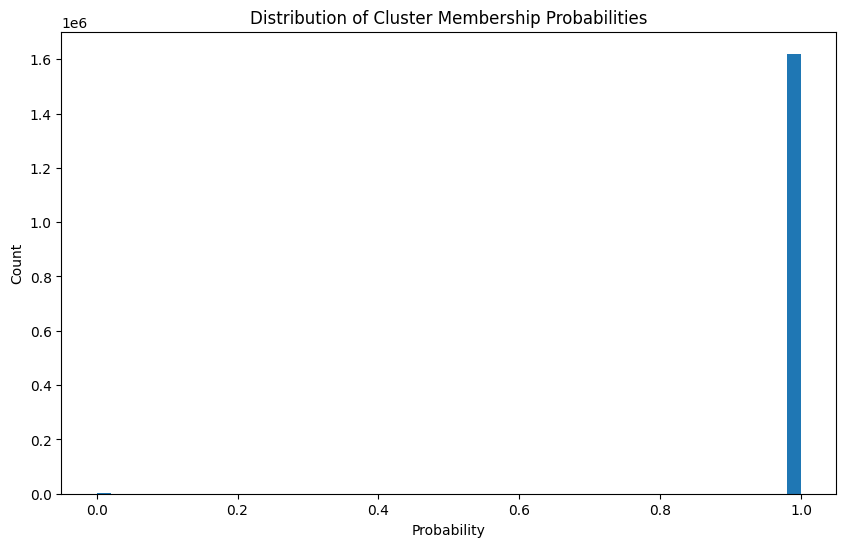

In [ ]:
# First, let's see how many clusters HDBSCAN found
# First check what we have
print(f"Number of points: {len(loaded_labels)}")
print(f"Number of clusters: {len(np.unique(loaded_labels))-1}")  # -1 to exclude noise cluster
print(f"Number of noise points: {np.sum(loaded_labels == -1)} ({np.sum(loaded_labels == -1)/len(loaded_labels):.2%})")

# Run the analysis function
analyze_clusters(reduced_embeddings, loaded_labels)

# Analyze probabilities
plt.figure(figsize=(10, 6))
plt.hist(loaded_probabilities[loaded_labels != -1], bins=50)
plt.title("Distribution of Cluster Membership Probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

Number of points: 1630607
Number of clusters: 137250
Number of noise points: 5928 (0.36%)
Total clusters: 6000
Non-empty clusters: 137251
Largest cluster: 5928 points
Smallest cluster: 5 points
Average cluster size: 11.9 points


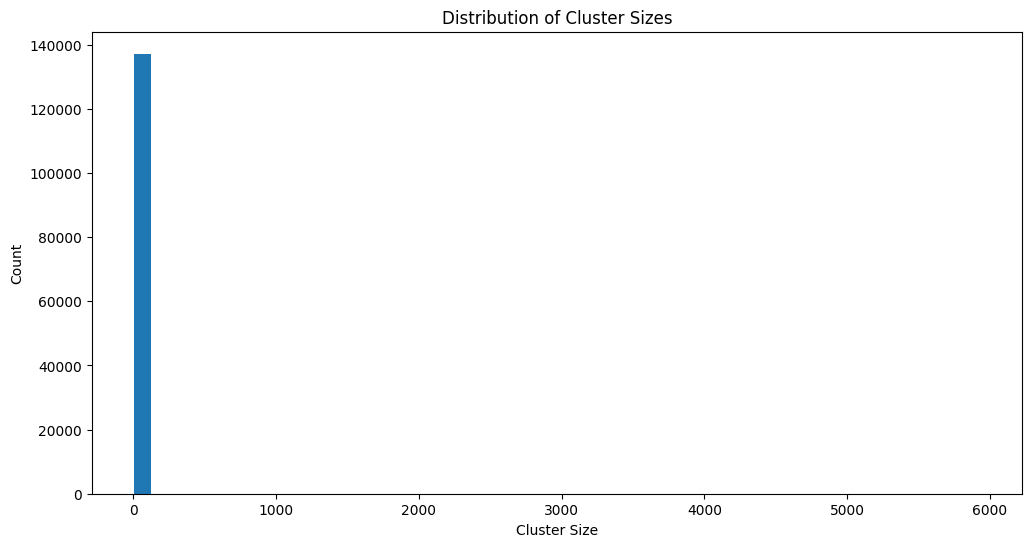

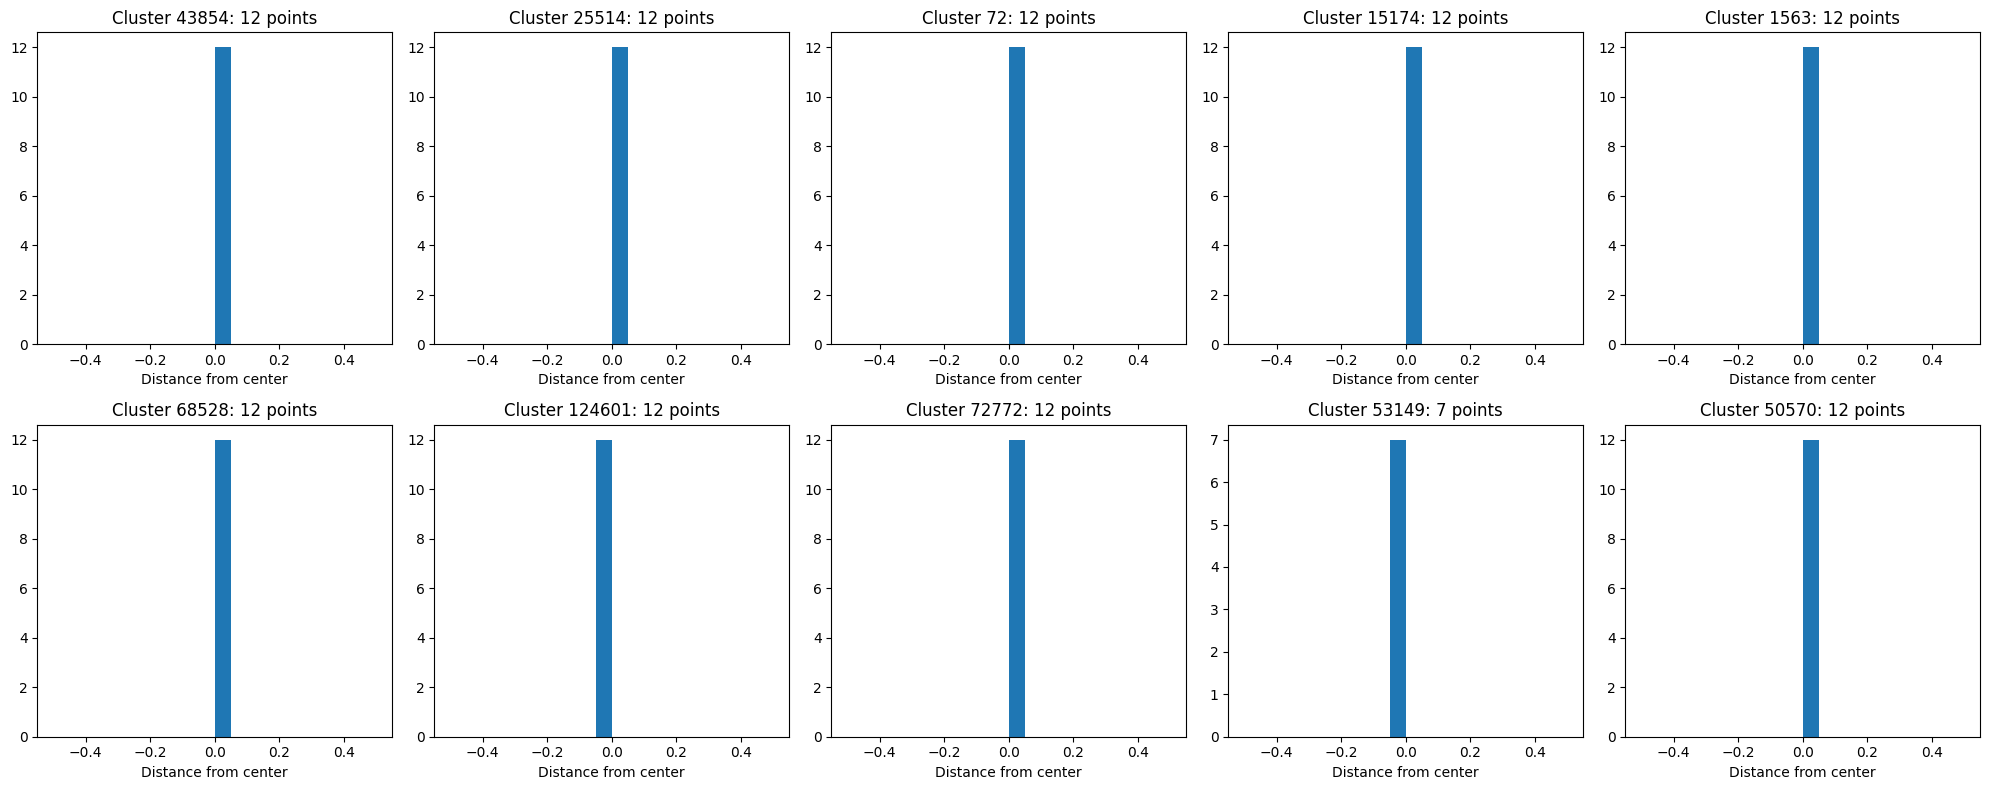

Computing metrics on a sample of 100,000 points...
Silhouette Score: 0.0639
Calinski-Harabasz Score: 115.11


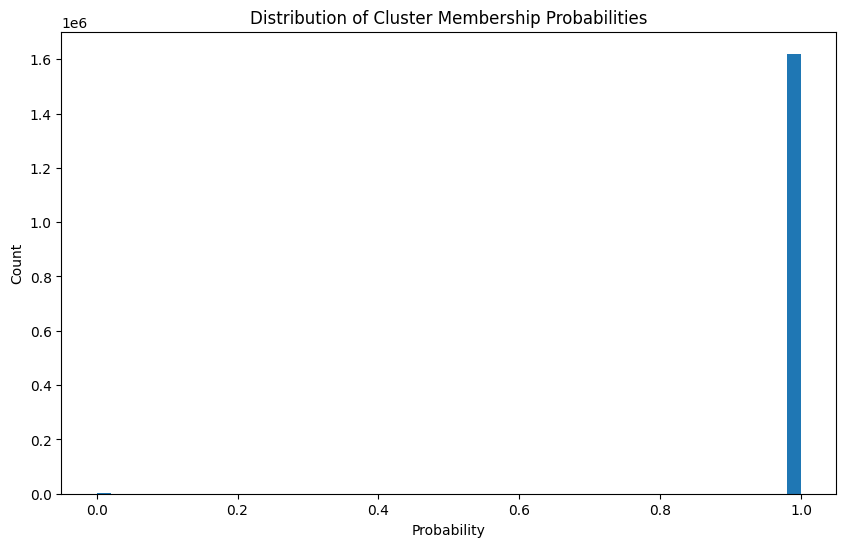

In [ ]:
# First, let's see how many clusters HDBSCAN found
# First check what we have
print(f"Number of points: {len(loaded_labels)}")
print(f"Number of clusters: {len(np.unique(loaded_labels))-1}")  # -1 to exclude noise cluster
print(f"Number of noise points: {np.sum(loaded_labels == -1)} ({np.sum(loaded_labels == -1)/len(loaded_labels):.2%})")

# Run the analysis function
analyze_clusters(reduced_embeddings, loaded_labels)

# Analyze probabilities
plt.figure(figsize=(10, 6))
plt.hist(loaded_probabilities[loaded_labels != -1], bins=50)
plt.title("Distribution of Cluster Membership Probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

Number of points: 1630607
Number of clusters: 137250
Number of noise points: 5928 (0.36%)
Total clusters: 6000
Non-empty clusters: 137251
Largest cluster: 5928 points
Smallest cluster: 5 points
Average cluster size: 11.9 points


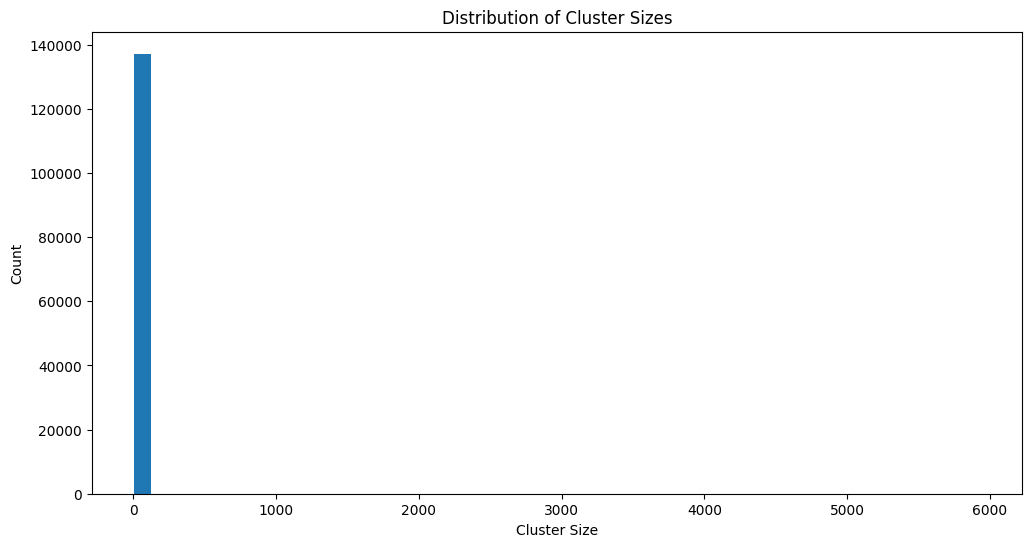

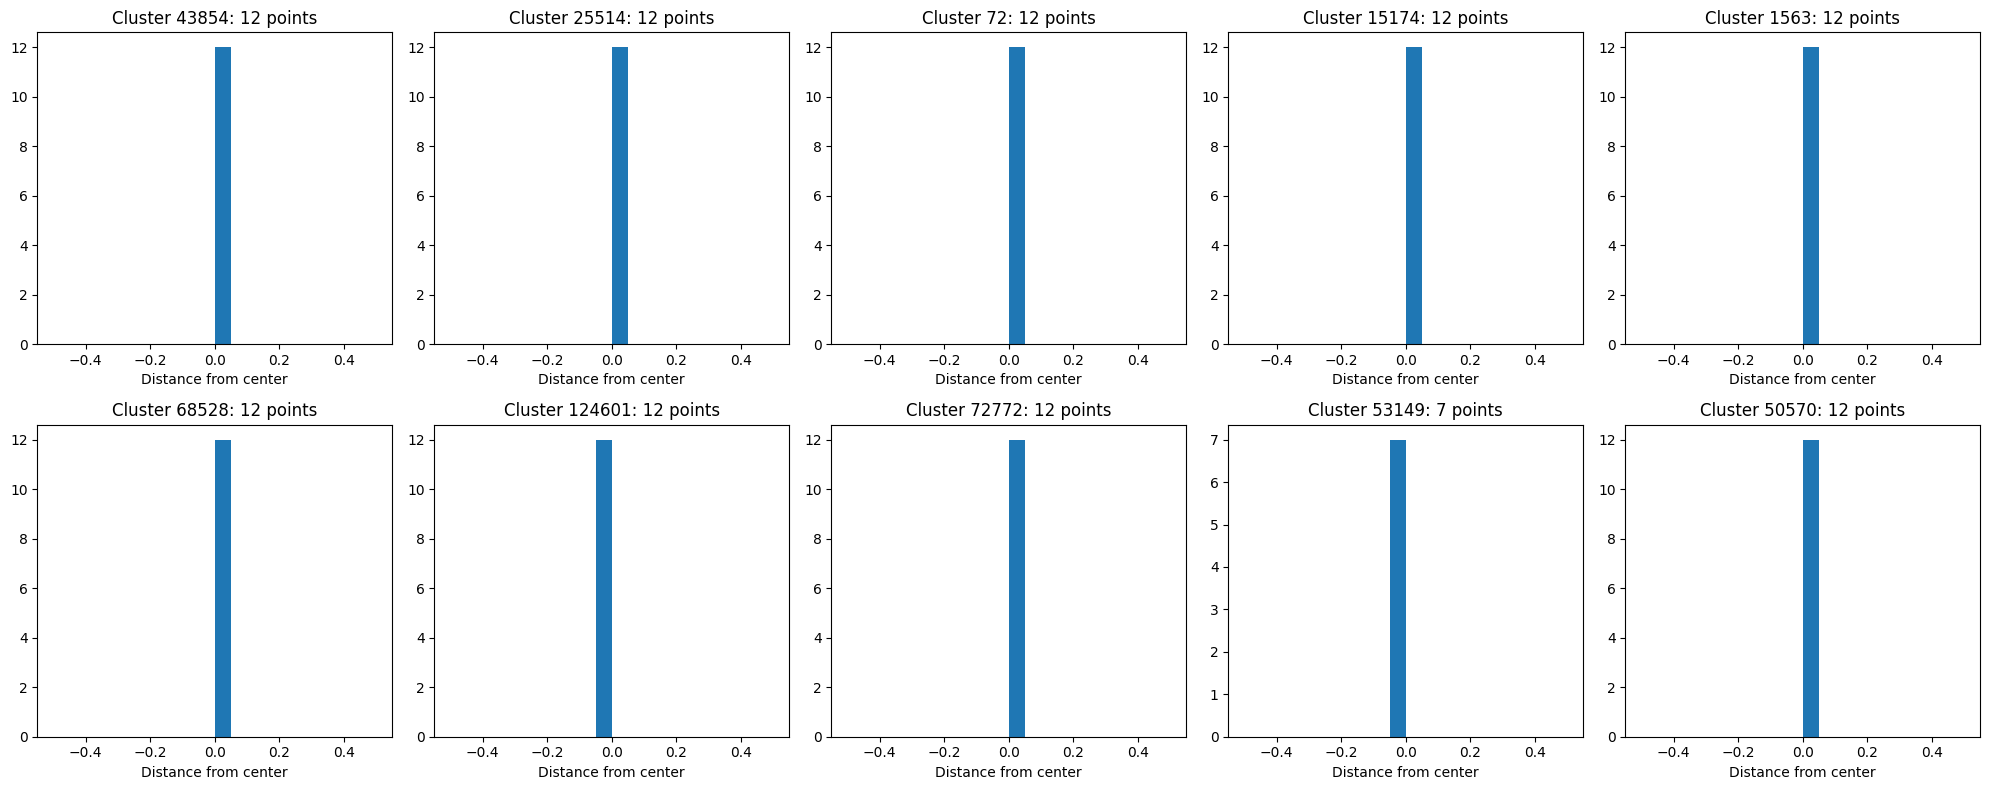

Computing metrics on a sample of 100,000 points...
Silhouette Score: 0.0639
Calinski-Harabasz Score: 115.11


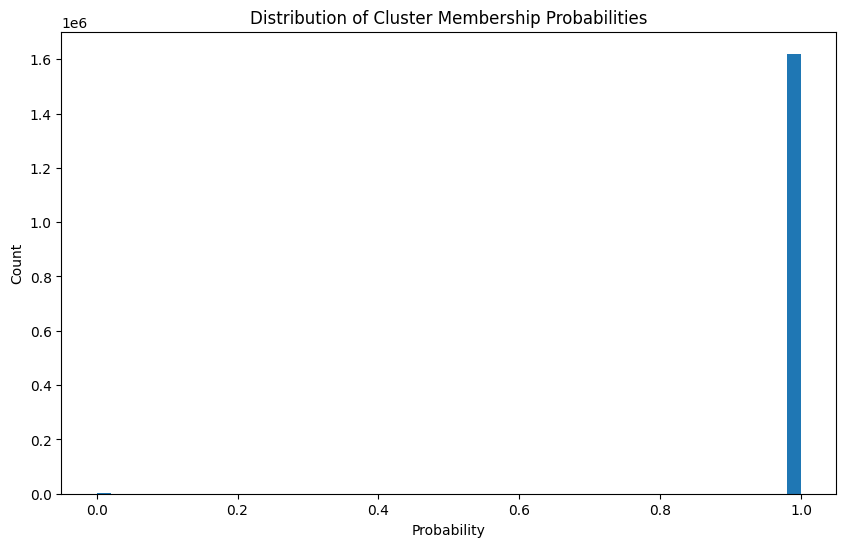

In [ ]:
# First, let's see how many clusters HDBSCAN found
# First check what we have
print(f"Number of points: {len(loaded_labels)}")
print(f"Number of clusters: {len(np.unique(loaded_labels))-1}")  # -1 to exclude noise cluster
print(f"Number of noise points: {np.sum(loaded_labels == -1)} ({np.sum(loaded_labels == -1)/len(loaded_labels):.2%})")

# Run the analysis function
analyze_clusters(reduced_embeddings, loaded_labels)

# Analyze probabilities
plt.figure(figsize=(10, 6))
plt.hist(loaded_probabilities[loaded_labels != -1], bins=50)
plt.title("Distribution of Cluster Membership Probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

## Subsample Clustering Test

In [13]:
import numpy as np
from sklearn.cluster import HDBSCAN
from joblib import Memory

# Set random seed for reproducibility
np.random.seed(42)

# Create a subsample of your data (100K points)
sample_size = 100000
sample_indices = np.random.choice(len(reduced_normalized_embeddings), sample_size, replace=False)
sample_data = reduced_normalized_embeddings[sample_indices]

# Save the sample indices for later reference
np.save('sample_indices.npy', sample_indices)

In [19]:
memory = Memory(location='./hdbscan_cache', verbose=0)

In [30]:
import numpy as np
import hdbscan
from joblib import Memory
from tqdm import tqdm
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

def evaluate_clustering(data, labels):
    """
    Calculate various clustering quality metrics
    """
    # Filter out noise points for metric calculation
    mask = labels != -1
    if len(np.unique(labels[mask])) < 2:
        return {
            'silhouette': None,
            'calinski_harabasz': None,
            'davies_bouldin': None,
            'relative_validity': None
        }
    
    try:
        # Silhouette Score: Range [-1, 1], higher is better
        # Measures how similar a point is to its own cluster compared to other clusters
        silhouette = silhouette_score(data[mask], labels[mask], sample_size=10000)
        
        # Calinski-Harabasz Index: Higher is better
        # Ratio of between-cluster dispersion and within-cluster dispersion
        calinski = calinski_harabasz_score(data[mask], labels[mask])
        
        # Davies-Bouldin Index: Lower is better
        # Average similarity measure of each cluster with its most similar cluster
        davies = davies_bouldin_score(data[mask], labels[mask])
        
        # HDBSCAN's relative validity metric
        relative_validity = np.mean(clusterer.relative_validity_)
        
        return {
            'silhouette': silhouette,
            'calinski_harabasz': calinski,
            'davies_bouldin': davies,
            'relative_validity': relative_validity
        }
    except:
        return {
            'silhouette': None,
            'calinski_harabasz': None,
            'davies_bouldin': None,
            'relative_validity': None
        }
def test_hdbscan_params(data, min_cluster_size, min_samples=None, cluster_selection_epsilon=0.0):
    """
    Test HDBSCAN with parameters and print detailed statistics
    """
    global clusterer  # Make accessible for relative validity calculation
    
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=cluster_selection_epsilon,
        metric='euclidean',
        cluster_selection_method='eom',
        core_dist_n_jobs=-1
    )
    
    labels = clusterer.fit_predict(data)
    
    # Basic clustering statistics
    n_clusters = len(np.unique(labels)) - 1  # -1 for noise
    noise_points = np.sum(labels == -1)
    noise_ratio = noise_points / len(labels)
    
    # Cluster size statistics
    unique_labels = np.unique(labels)
    cluster_sizes = [np.sum(labels == label) for label in unique_labels if label != -1]
    
    if cluster_sizes:
        max_cluster = max(cluster_sizes)
        min_cluster = min(cluster_sizes)
        avg_cluster = np.mean(cluster_sizes)
    else:
        max_cluster = min_cluster = avg_cluster = 0
    
    print(f"\nResults for min_cluster_size={min_cluster_size}, min_samples={min_samples}")
    print(f"Number of points: {len(labels)}")
    print(f"Number of clusters: {n_clusters}")
    print(f"Noise points: {noise_points} ({noise_ratio:.2%})")
    if cluster_sizes:
        print(f"Largest cluster: {max_cluster} points")
        print(f"Smallest cluster: {min_cluster} points")
        print(f"Average cluster size: {avg_cluster:.1f} points")
    
    # Only calculate metrics if we have more than one cluster and non-noise points
    metrics = {}
    if n_clusters > 1 and len(labels[labels != -1]) > 0:
        try:
            # Filter out noise points for metric calculation
            mask = labels != -1
            data_clean = data[mask]
            labels_clean = labels[mask]
            
            if len(np.unique(labels_clean)) > 1:
                # Silhouette Score
                try:
                    silhouette = silhouette_score(data_clean, labels_clean, sample_size=min(10000, len(data_clean)))
                    metrics['silhouette'] = silhouette
                except:
                    metrics['silhouette'] = None
                
                # Calinski-Harabasz Score
                try:
                    calinski = calinski_harabasz_score(data_clean, labels_clean)
                    metrics['calinski_harabasz'] = calinski
                except:
                    metrics['calinski_harabasz'] = None
                
                # Davies-Bouldin Score
                try:
                    davies = davies_bouldin_score(data_clean, labels_clean)
                    metrics['davies_bouldin'] = davies
                except:
                    metrics['davies_bouldin'] = None
                
                # HDBSCAN's relative validity
                try:
                    metrics['relative_validity'] = np.mean(clusterer.relative_validity_)
                except:
                    metrics['relative_validity'] = None
            else:
                metrics = {
                    'silhouette': None,
                    'calinski_harabasz': None,
                    'davies_bouldin': None,
                    'relative_validity': None
                }
        except Exception as e:
            print(f"Error calculating metrics: {str(e)}")
            metrics = {
                'silhouette': None,
                'calinski_harabasz': None,
                'davies_bouldin': None,
                'relative_validity': None
            }
    else:
        metrics = {
            'silhouette': None,
            'calinski_harabasz': None,
            'davies_bouldin': None,
            'relative_validity': None
        }
    
    print("\nClustering Quality Metrics:")
    print(f"Silhouette Score: {metrics.get('silhouette', 'N/A')}")
    print(f"Calinski-Harabasz Score: {metrics.get('calinski_harabasz', 'N/A')}")
    print(f"Davies-Bouldin Score: {metrics.get('davies_bouldin', 'N/A')}")
    print(f"HDBSCAN Relative Validity: {metrics.get('relative_validity', 'N/A')}")
    print("-" * 50)
    
    return labels, metrics


In [31]:
# Test combinations including defaults and gradual increases
param_combinations = [
    # Default parameters
    {'min_cluster_size': 5, 'min_samples': None},
    
    # Slightly increased from default
    {'min_cluster_size': 10, 'min_samples': None},
    {'min_cluster_size': 20, 'min_samples': None},
    
    # Medium values
    {'min_cluster_size': 50, 'min_samples': None},
    {'min_cluster_size': 50, 'min_samples': 10},
    
    # Larger values
    {'min_cluster_size': 100, 'min_samples': None},
    {'min_cluster_size': 100, 'min_samples': 20},
    
    # Very large values
    {'min_cluster_size': 500, 'min_samples': 50},
    {'min_cluster_size': 1000, 'min_samples': 100}
]


# Store results with metrics
results = {}

# Run tests with progress bar
print("Testing parameter combinations on sample data...")
for params in tqdm(param_combinations):
    key = f"mcs_{params['min_cluster_size']}_ms_{params['min_samples']}"
    labels, metrics = test_hdbscan_params(sample_data, **params)
    results[key] = {
        'labels': labels,
        'metrics': metrics,
        'params': params
    }

# Analyze and compare results
print("\nSummary of Best Parameters:")
metric_rankings = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': [],
    'relative_validity': []
}

for key, result in results.items():
    metrics = result['metrics']
    if metrics['silhouette'] is not None:
        metric_rankings['silhouette'].append((metrics['silhouette'], key))
    if metrics['calinski_harabasz'] is not None:
        metric_rankings['calinski_harabasz'].append((metrics['calinski_harabasz'], key))
    if metrics['davies_bouldin'] is not None:
        metric_rankings['davies_bouldin'].append((metrics['davies_bouldin'], key))
    if metrics['relative_validity'] is not None:
        metric_rankings['relative_validity'].append((metrics['relative_validity'], key))

print("\nBest parameters according to different metrics:")
print("\nSilhouette Score (higher is better):")
for score, key in sorted(metric_rankings['silhouette'], reverse=True)[:3]:
    print(f"{key}: {score:.3f}")

print("\nCalinski-Harabasz Score (higher is better):")
for score, key in sorted(metric_rankings['calinski_harabasz'], reverse=True)[:3]:
    print(f"{key}: {score:.1f}")

print("\nDavies-Bouldin Score (lower is better):")
for score, key in sorted(metric_rankings['davies_bouldin'])[:3]:
    print(f"{key}: {score:.3f}")

print("\nHDBSCAN Relative Validity (higher is better):")
for score, key in sorted(metric_rankings['relative_validity'], reverse=True)[:3]:
    print(f"{key}: {score:.3f}")

Testing parameter combinations on sample data...


  0%|          | 0/9 [00:00<?, ?it/s]


Results for min_cluster_size=5, min_samples=None
Number of points: 100000
Number of clusters: 1590
Noise points: 86445 (86.45%)
Largest cluster: 86 points
Smallest cluster: 5 points
Average cluster size: 8.5 points


 11%|█         | 1/9 [00:44<05:54, 44.31s/it]


Clustering Quality Metrics:
Silhouette Score: 0.37357276678085327
Calinski-Harabasz Score: 402.5882263183594
Davies-Bouldin Score: 0.9666610171543911
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=10, min_samples=None
Number of points: 100000
Number of clusters: 48
Noise points: 74914 (74.91%)
Largest cluster: 23916 points
Smallest cluster: 10 points
Average cluster size: 522.6 points


 22%|██▏       | 2/9 [01:24<04:51, 41.69s/it]


Clustering Quality Metrics:
Silhouette Score: -0.07292983680963516
Calinski-Harabasz Score: 167.57870483398438
Davies-Bouldin Score: 0.8832403113709612
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=20, min_samples=None
Number of points: 100000
Number of clusters: 2
Noise points: 23064 (23.06%)
Largest cluster: 76909 points
Smallest cluster: 27 points
Average cluster size: 38468.0 points


 33%|███▎      | 3/9 [02:02<04:02, 40.38s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5385400652885437
Calinski-Harabasz Score: 213.904296875
Davies-Bouldin Score: 0.41194302623946516
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=50, min_samples=None
Number of points: 100000
Number of clusters: 2
Noise points: 56673 (56.67%)
Largest cluster: 42984 points
Smallest cluster: 343 points
Average cluster size: 21663.5 points


 44%|████▍     | 4/9 [02:41<03:17, 39.56s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5393354296684265
Calinski-Harabasz Score: 2554.130859375
Davies-Bouldin Score: 0.48191837142396365
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=50, min_samples=10
Number of points: 100000
Number of clusters: 2
Noise points: 18623 (18.62%)
Largest cluster: 81326 points
Smallest cluster: 51 points
Average cluster size: 40688.5 points


 56%|█████▌    | 5/9 [03:20<02:38, 39.50s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5160714387893677
Calinski-Harabasz Score: 373.5559997558594
Davies-Bouldin Score: 0.4593791508810631
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=100, min_samples=None
Number of points: 100000
Number of clusters: 2
Noise points: 56834 (56.83%)
Largest cluster: 42941 points
Smallest cluster: 225 points
Average cluster size: 21583.0 points


 67%|██████▋   | 6/9 [04:00<01:59, 39.76s/it]


Clustering Quality Metrics:
Silhouette Score: 0.540977418422699
Calinski-Harabasz Score: 1670.1837158203125
Davies-Bouldin Score: 0.4478271179527509
HDBSCAN Relative Validity: None
--------------------------------------------------

Results for min_cluster_size=100, min_samples=20
Number of points: 100000
Number of clusters: 2
Noise points: 61676 (61.68%)
Largest cluster: 37819 points
Smallest cluster: 505 points
Average cluster size: 19162.0 points


 78%|███████▊  | 7/9 [04:40<01:19, 39.54s/it]


Clustering Quality Metrics:
Silhouette Score: 0.5340943336486816
Calinski-Harabasz Score: 3448.697021484375
Davies-Bouldin Score: 0.5865703040962778
HDBSCAN Relative Validity: None
--------------------------------------------------


 89%|████████▉ | 8/9 [05:19<00:39, 39.47s/it]


Results for min_cluster_size=500, min_samples=50
Number of points: 100000
Number of clusters: 0
Noise points: 100000 (100.00%)

Clustering Quality Metrics:
Silhouette Score: None
Calinski-Harabasz Score: None
Davies-Bouldin Score: None
HDBSCAN Relative Validity: None
--------------------------------------------------


100%|██████████| 9/9 [06:00<00:00, 40.10s/it]


Results for min_cluster_size=1000, min_samples=100
Number of points: 100000
Number of clusters: 0
Noise points: 100000 (100.00%)

Clustering Quality Metrics:
Silhouette Score: None
Calinski-Harabasz Score: None
Davies-Bouldin Score: None
HDBSCAN Relative Validity: None
--------------------------------------------------

Summary of Best Parameters:

Best parameters according to different metrics:

Silhouette Score (higher is better):
mcs_100_ms_None: 0.541
mcs_50_ms_None: 0.539
mcs_20_ms_None: 0.539

Calinski-Harabasz Score (higher is better):
mcs_100_ms_20: 3448.7
mcs_50_ms_None: 2554.1
mcs_100_ms_None: 1670.2

Davies-Bouldin Score (lower is better):
mcs_20_ms_None: 0.412
mcs_100_ms_None: 0.448
mcs_50_ms_10: 0.459

HDBSCAN Relative Validity (higher is better):
